<a href="https://colab.research.google.com/github/LuciaArias03/ProyectoParteIII-Arias.ipynb/blob/main/ProyectoDSParteI_Arias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##📌 **Abstract**
    
  Este proyecto utiliza el dataset “Global Cybersecurity Threats ” proveniente de Kaggle, que contiene más de 3.000 amenazas a la ciberseguridad que se han dado globalmente entre los años 2015 y 2024. La base proporciona información exhaustiva sobre ciberataques, tipos de malware, sectores objetivo y países afectados.
  
  Está diseñado para el análisis de inteligencia de amenazas, la previsión de tendencias de ciberseguridad y el desarrollo de modelos de aprendizaje automático para mejorar la seguridad digital global.

### ❓ Preguntas / Hipótesis de interés
1. ¿Cuántos ciberataques sufrieron cada país?
2. ¿Cuántas veces se vulneró cada sistema de seguridad?.
3. Cada ciberataque tuvo como objetivo afectar una industria, ¿cuántas veces fueron afectadas cada una?
4. ¿De cuántos millones de dolares fue la pérdida financiera en cada país?
5. ¿Cuántos millones de usuarios fueron afectados en cada año? Independientemente del país.
6. ¿Existe una relación entre el tipo de fuente del que proviene el ataque con el país afectado?

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import mutual_info_classif, chi2, SelectKBest
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             mean_absolute_error, mean_squared_error, r2_score, roc_curve, roc_auc_score)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [82]:
# Cargar datos
df_ataques = pd.read_csv('/content/Global_Cybersecurity_Threats_Lucia.csv')
df_ataques.head(5)

,Country,Year,Attack_Type,Target_Industry,Financial_Loss,Affected_Users,Attack_Source,Security_Vulnerability_Type,Defense_Mechanism_Used,Incident_Resolution_Time
0,China,2019,Phishing,Education,80.53,773169,Hacker Group,Unpatched Software,VPN,63
1,China,2019,Ransomware,Retail,62.19,295961,Hacker Group,Unpatched Software,Firewall,71
2,India,2017,Man-in-the-Middle,IT,38.65,605895,Hacker Group,Weak Passwords,VPN,20
3,UK,2024,Ransomware,Telecommunications,41.44,659320,Nation-state,Social Engineering,AI-based Detection,7
4,Germany,2018,Man-in-the-Middle,IT,74.41,810682,Insider,Social Engineering,VPN,68


In [83]:
missing = df_ataques.isna().sum().sort_values(ascending=False)
missing[missing > 0]

,0


In [84]:
df_ataques.shape

(3000, 10)

In [85]:
df_ataques.dtypes

,0
Country,object
Year,int64
Attack_Type,object
Target_Industry,object
Financial_Loss,float64
Affected_Users,int64
Attack_Source,object
Security_Vulnerability_Type,object
Defense_Mechanism_Used,object
Incident_Resolution_Time,int64


In [86]:
# Contar la frecuencia de cada país
conteo_Country = df_ataques['Country'].value_counts()

print("Frecuencia de Ataques por País:")
print(conteo_Country)

Frecuencia de Ataques por País:
Country
UK           321
Brazil       310
India        308
Japan        305
France       305
Australia    297
Russia       295
Germany      291
USA          287
China        281
Name: count, dtype: int64


In [87]:
# Contar el tipo de seguridad fue más veces vulnerada
conteo_Security_Vulnerability = df_ataques['Security_Vulnerability_Type'].value_counts()

print("Qué tipo de seguridad fue más veces vulnerada?")
print(conteo_Security_Vulnerability)

Qué tipo de seguridad fue más veces vulnerada?
Security_Vulnerability_Type
Zero-day              785
Social Engineering    747
Unpatched Software    738
Weak Passwords        730
Name: count, dtype: int64


In [88]:
# Contar cuántas veces fue atacada cada industria
conteo_Target_Industry = df_ataques['Target_Industry'].value_counts()

print("¿Cuántas veces fue atacada cada industria?")
print(conteo_Target_Industry)

¿Cuántas veces fue atacada cada industria?
Target_Industry
IT                    478
Banking               445
Healthcare            429
Retail                423
Education             419
Government            403
Telecommunications    403
Name: count, dtype: int64


In [89]:
# Contar los macanismos de defensa utilizados
conteo_Defense_Mechanism_Used = df_ataques['Defense_Mechanism_Used'].value_counts()

print("Los mecanismos utilizados fueron los siguientes:")
print(conteo_Defense_Mechanism_Used)

Los mecanismos utilizados fueron los siguientes:
Defense_Mechanism_Used
Antivirus             628
VPN                   612
Encryption            592
Firewall              585
AI-based Detection    583
Name: count, dtype: int64


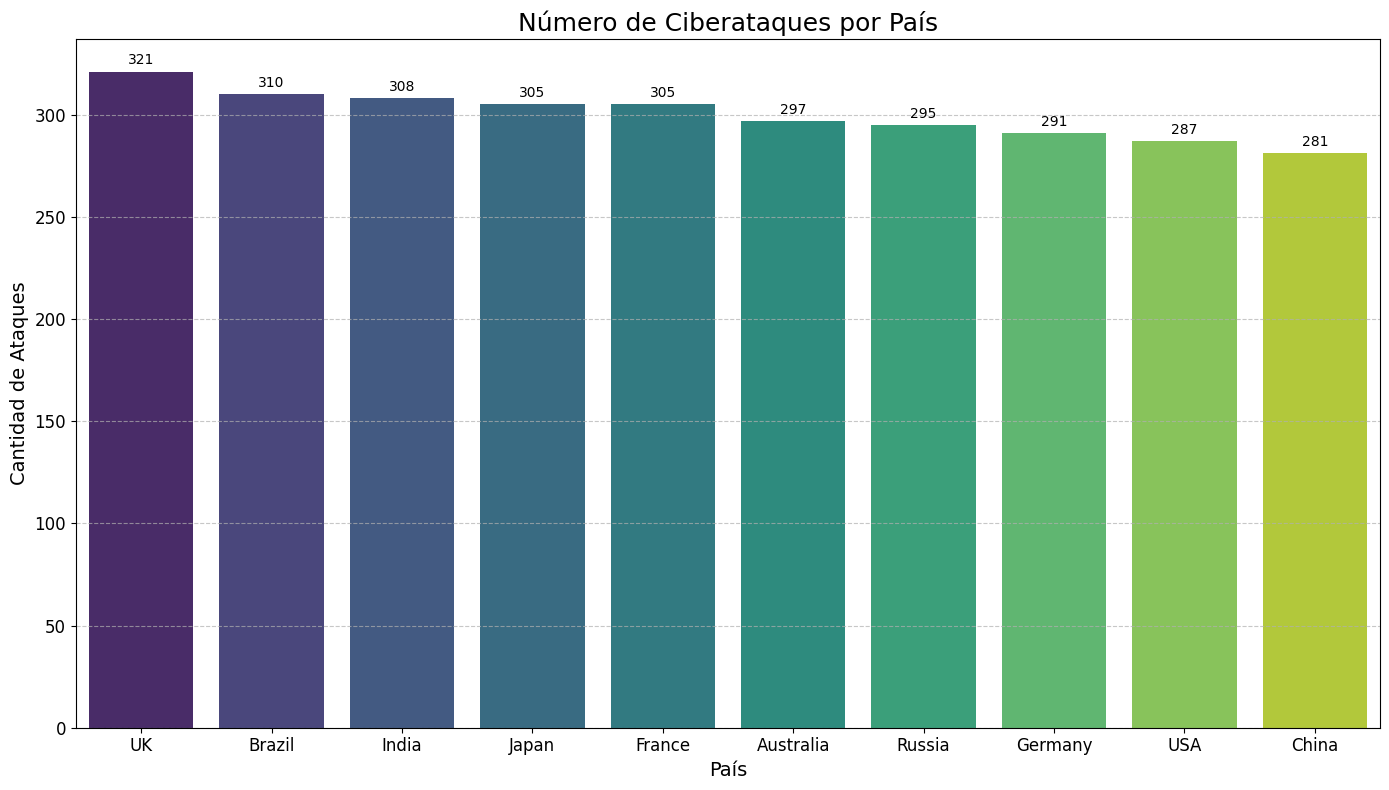

In [90]:
plt.figure(figsize=(14, 8))
ax = sns.barplot(x=conteo_Country.index, y=conteo_Country.values, palette='viridis', hue=conteo_Country.index, legend=False)

plt.title('Número de Ciberataques por País', fontsize=18)
plt.xlabel('País', fontsize=14)
plt.ylabel('Cantidad de Ataques', fontsize=14)
plt.xticks(rotation=0, ha='center', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', fontsize=10, padding=3)

plt.tight_layout()
plt.show()

✅ UK, Brasil e India son los paises que han experimentado la mayor cantidad de ciberataques, representados por las barras más altas.

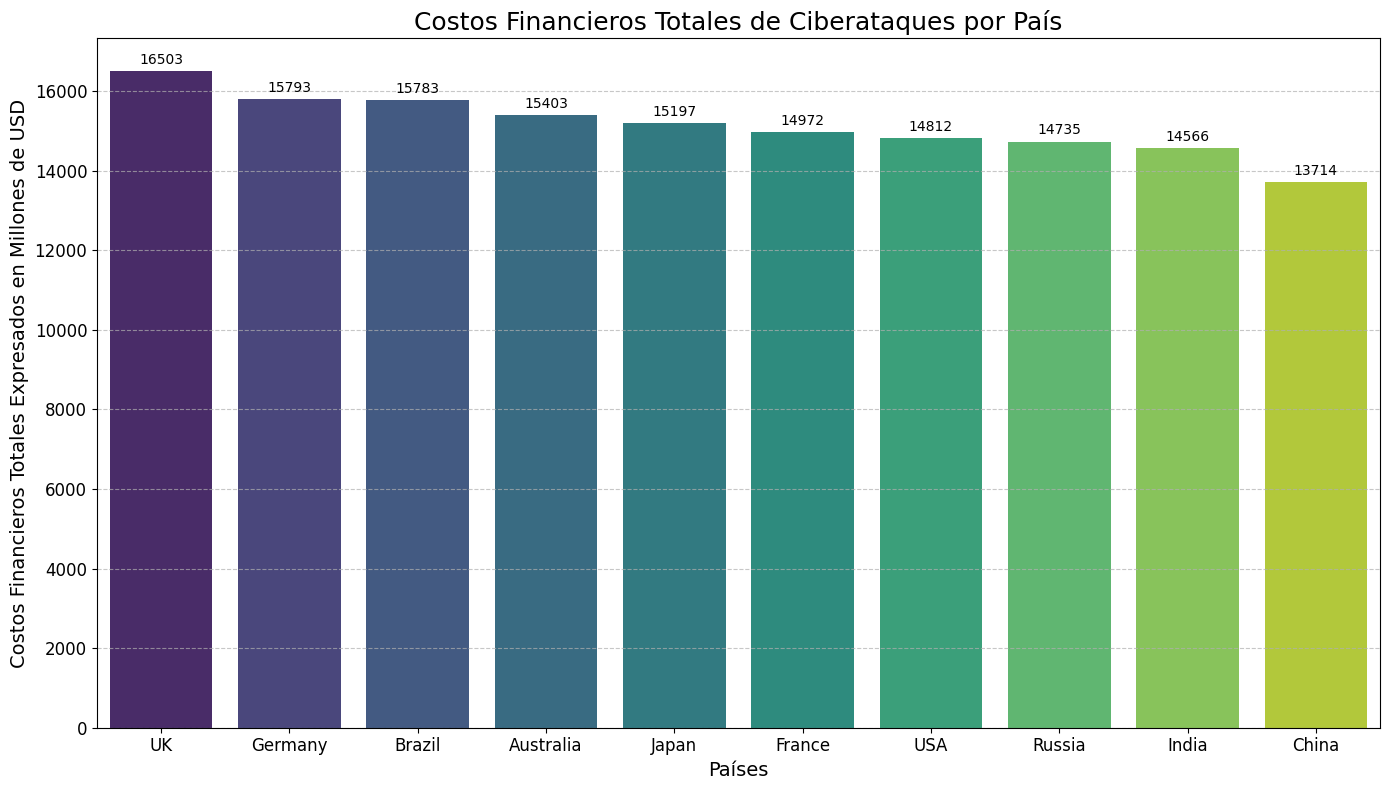

In [91]:
df_ataques['Financial_Loss'] = pd.to_numeric(df_ataques['Financial_Loss'], errors='coerce').fillna(0)

costos_totales_por_pais = df_ataques.groupby('Country')['Financial_Loss'].sum().reset_index()

costos_totales_por_pais = costos_totales_por_pais.sort_values(by='Financial_Loss', ascending=False)

plt.figure(figsize=(14, 8))

ax = sns.barplot(
    data=costos_totales_por_pais,
    x='Country',
    y='Financial_Loss',
    palette='viridis',

    hue='Country',
    legend=False
)

plt.title('Costos Financieros Totales de Ciberataques por País', fontsize=18)
plt.xlabel('Países', fontsize=14)
plt.ylabel('Costos Financieros Totales Expresados en Millones de USD', fontsize=14)
plt.xticks(rotation=0, ha='center', fontsize=12)
plt.yticks(fontsize=12)

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', fontsize=10, padding=3)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

✅ Sin embargo, Alemania que no quedó en el top 3 de los paises mas atacados, quedó en el segundo puesto en cuanto a los costos que ha perdido por los ataquer recibidos.

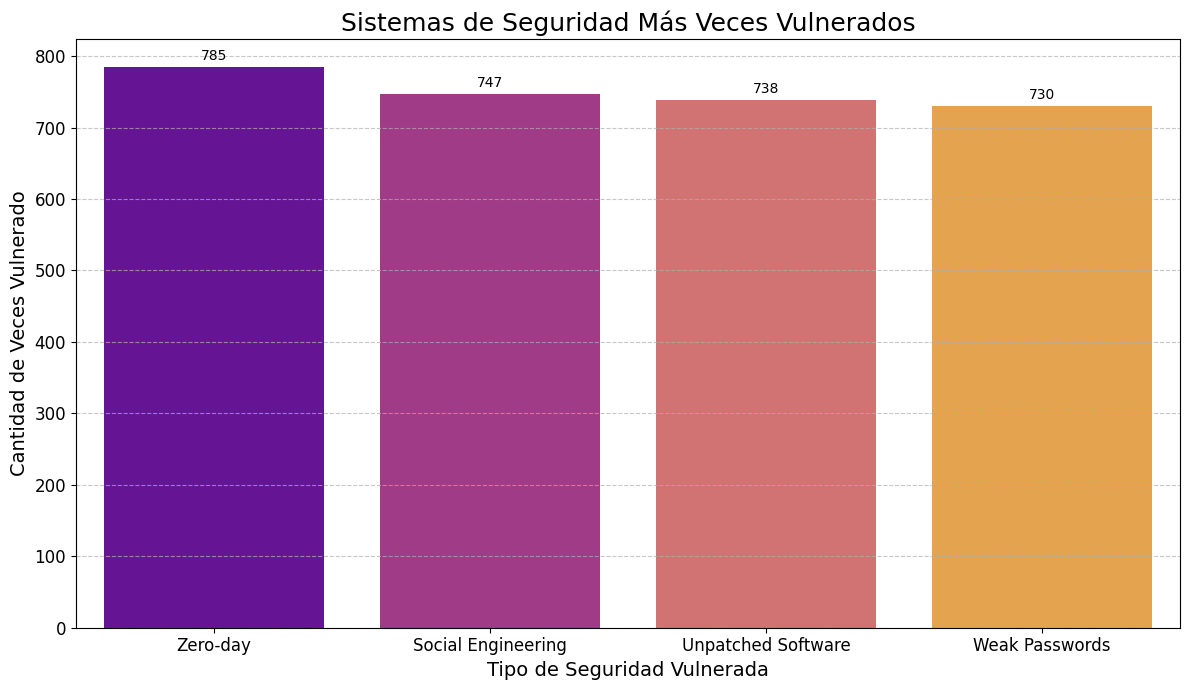

In [92]:
plt.figure(figsize=(12, 7))
ax = sns.barplot(x=conteo_Security_Vulnerability.index, y=conteo_Security_Vulnerability.values, palette='plasma',
                 hue=conteo_Security_Vulnerability.index, legend=False)

plt.title('Sistemas de Seguridad Más Veces Vulnerados', fontsize=18)
plt.xlabel('Tipo de Seguridad Vulnerada', fontsize=14)
plt.ylabel('Cantidad de Veces Vulnerado', fontsize=14)

plt.xticks(rotation=0, ha='center', fontsize=12)

plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', fontsize=10, padding=3)

plt.tight_layout()
plt.show()

✅ De los 4 sistemas de seguridad que estuvimos analizando, "Zero-day" fue el más veces vulnerado con 785 ataques exitosos. Las "Weak Passwords" quedaron en el cuarto lugar con 730 veces vulneradas. Ya vemos que nos valores no difieren enormemente entre los 4 tipo de seguridad.

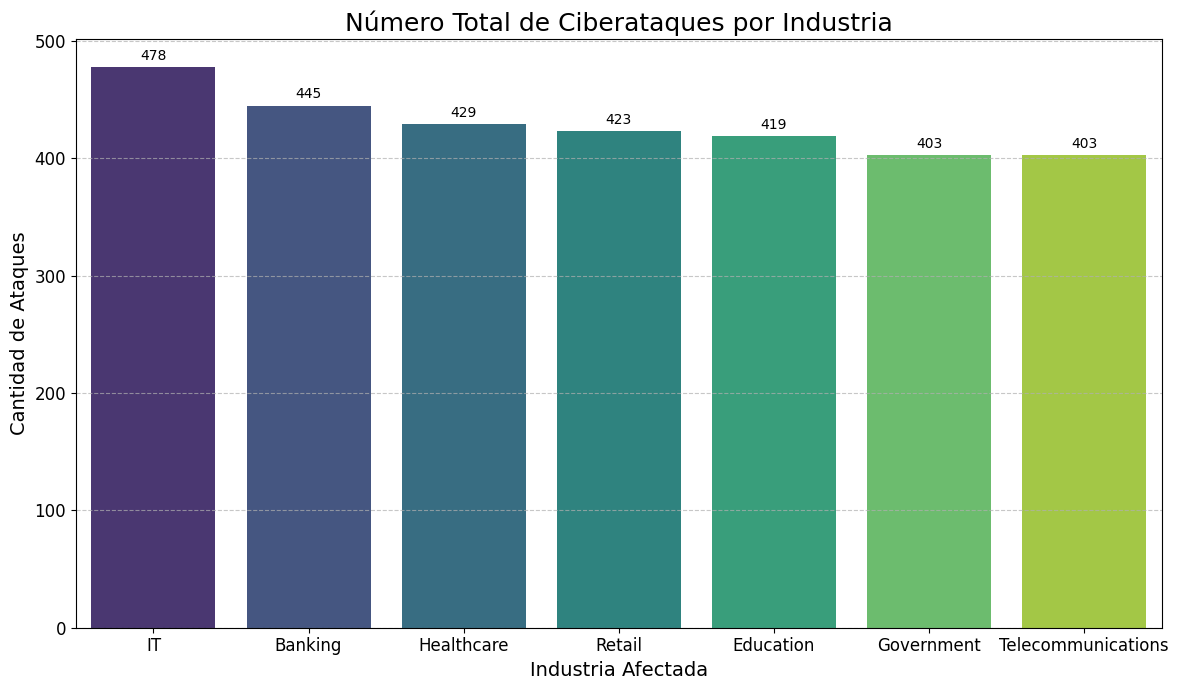

In [93]:
plt.figure(figsize=(12, 7))
ax = sns.barplot(x=conteo_Target_Industry.index, y=conteo_Target_Industry.values, palette='viridis', hue=conteo_Target_Industry.index, legend=False)

plt.title('Número Total de Ciberataques por Industria', fontsize=18)
plt.xlabel('Industria Afectada', fontsize=14)
plt.ylabel('Cantidad de Ataques', fontsize=14)
plt.xticks(rotation=0, ha='center', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', fontsize=10, padding=3)

plt.tight_layout()
plt.show()

✅ La industria mas afectado fue IT.

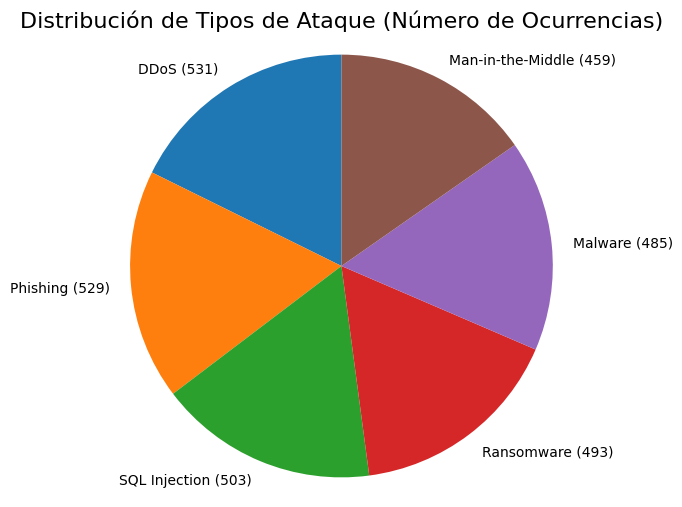

In [94]:
# Contar la frecuencia de cada tipo de ataque
attack_type_counts = df_ataques['Attack_Type'].value_counts()

# --- 3. Creación del Gráfico de Torta ---
plt.figure(figsize=(6, 6)) # Un tamaño ligeramente mayor puede ayudar con las etiquetas

# Preparamos las etiquetas personalizadas para incluir el nombre y el número de ocurrencias
labels = [f"{name} ({count})" for name, count in attack_type_counts.items()]

# Crear el gráfico de torta
# NOTA: Quitamos autopct, y pasamos las etiquetas personalizadas
plt.pie(attack_type_counts, labels=labels, startangle=90, pctdistance=0.85)
# pctdistance=0.85 mueve las etiquetas de los porcentajes (que ya no están) hacia el centro si estuvieran

# Añadir un título al gráfico
plt.title('Distribución de Tipos de Ataque (Número de Ocurrencias)', fontsize=16)

# Asegurar que el gráfico sea un círculo perfecto (no ovalado)
plt.axis('equal')

plt.show()

✅ Con el grafico de torta tambien podemos ver que entre los tipos de ataques utilizados tampoco hay uno que se destaque por utilizarce mas que otros.

Primeras filas de la cantidad de usuarios afectados por año:
   Year  Affected_Users
0  2015       141293170
1  2016       144034584
2  2017       161807880
3  2018       151774954
4  2019       130212928
5  2020       159036761
6  2021       155241999
7  2022       163263160
8  2023       154305656
9  2024       153081317


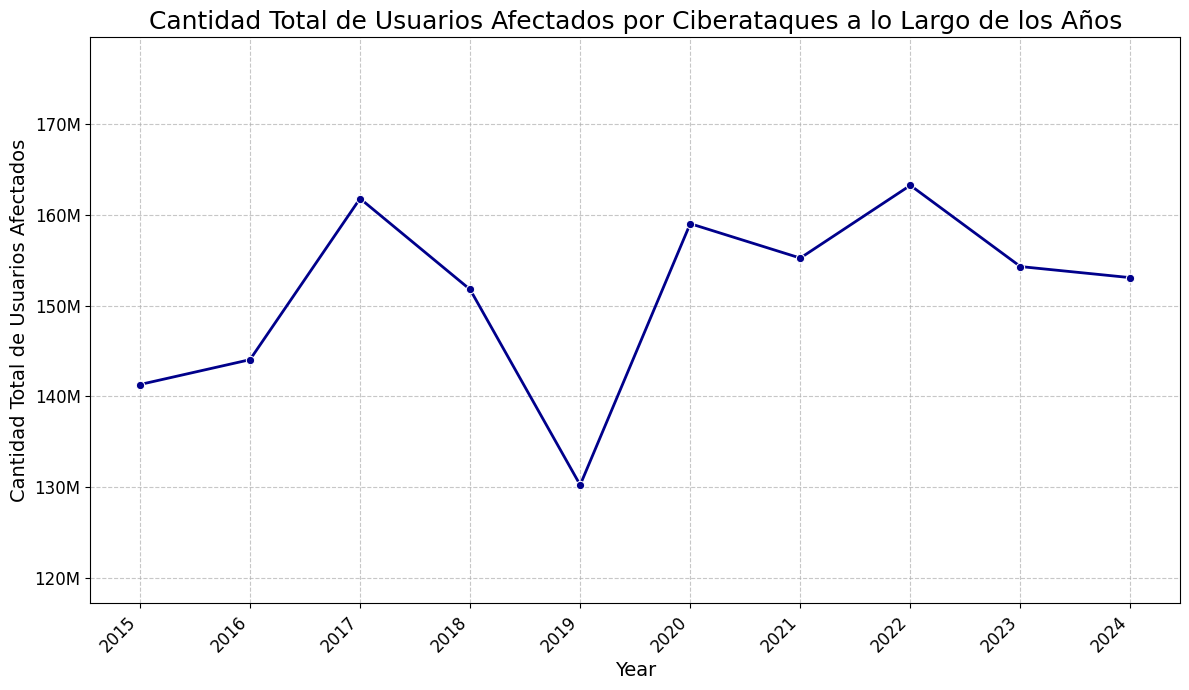

In [95]:
usuarios_afectados_anual = df_ataques.groupby('Year')['Affected_Users'].sum().reset_index()

print("Primeras filas de la cantidad de usuarios afectados por año:")
print(usuarios_afectados_anual.head(10))

plt.figure(figsize=(12, 7))

sns.lineplot(
    data=usuarios_afectados_anual,
    x='Year',
    y='Affected_Users',
    marker='o',
    linestyle='-',
    color='darkblue',
    linewidth=2
)

plt.title('Cantidad Total de Usuarios Afectados por Ciberataques a lo Largo de los Años', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Cantidad Total de Usuarios Afectados', fontsize=14)

min_val_y = usuarios_afectados_anual['Affected_Users'].min()
max_val_y = usuarios_afectados_anual['Affected_Users'].max()

margin_y_bottom = min_val_y * 0.9 if min_val_y > 0 else 0
margin_y_top = max_val_y * 1.1

plt.ylim(margin_y_bottom, margin_y_top)

def format_millions(x, pos):
    if x >= 1e9:
        return f'{x*1e-9:.0f}B' # Billions
    elif x >= 1e6:
        return f'{x*1e-6:.0f}M' # Millions
    elif x >= 1e3:
        return f'{x*1e-3:.0f}K' # Thousands
    else:
        return f'{x:.0f}'

from matplotlib.ticker import FuncFormatter
formatter = FuncFormatter(format_millions)
plt.gca().yaxis.set_major_formatter(formatter)

plt.xticks(
    usuarios_afectados_anual['Year'].astype(int),
    rotation=45,
    ha='right',
    fontsize=12
)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

✅ Con el grafico de linea podemos ver a simple vista que el año 2019 fue el año donde menos usuarios fueron afectado por algun ciberataque.

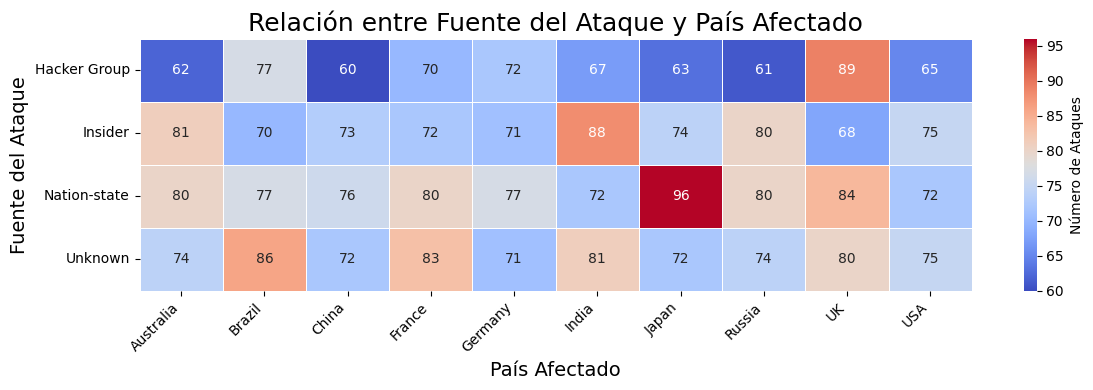

In [96]:
contingency_table_fuente_pais = pd.crosstab(df_ataques['Attack_Source'], df_ataques['Country'])

plt.figure(figsize=(12, 4))

sns.heatmap(
    contingency_table_fuente_pais,
    annot=True,
    fmt='d',
    cmap='coolwarm',
    linewidths=.5,
    cbar_kws={'label': 'Número de Ataques'}
)

plt.title('Relación entre Fuente del Ataque y País Afectado', fontsize=18)
plt.xlabel('País Afectado', fontsize=14)
plt.ylabel('Fuente del Ataque', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

## ✅ Conclusiones preliminares

*   Reino Unido fue el pais que mas ciberataque tuvo, por lo tanto tiene la mayor cantidad de usuarios afectados. Sin embargo, Alemania es uno de los paises que afectaron menos veces, pero es el segundo con usuarios mas afectados.
*   Aunque no haya gran diferecia entre la cantidad de veces que se volneró cada sistema de seguridad, la mas afectada por "Zero-day"
*   Como era de esperarse, la industria que fue objetivo mas veces fue la IT, ya que es área que abarca todo lo relacionado con la informática y las comunicaciones.
*   El año en que ocurrieron mas ciberataques fue el 2022.
*   Japón tiene mas ciberataques provenientes de los grupos llamados "Nation-state".





📌 La combinación del métodos de filtro con las características de un modelo basado en árboles (Random Forest) me permitirá identificar las columnas más influyentes tanto de forma individual como en sus interacciones, lo cual es vital para comprender los patrones en los ciberataques y para construir modelos efectivos.

In [97]:
df_ataques.columns = df_ataques.columns.str.strip()
df_ataques.columns = df_ataques.columns.str.lower()

num_cols_to_process = ['financial_loss', 'affected_users', 'year']
for col_name in num_cols_to_process:
    if col_name in df_ataques.columns:
        # Intenta convertir a numérico, si falla, cohíbe a NaN.
        df_ataques[col_name] = pd.to_numeric(df_ataques[col_name], errors='coerce')
        # Para 'year', los NaNs se eliminan porque es una clave de agrupación.
        # Para pérdidas/usuarios, los NaNs se rellenan con 0 (o la mediana, dependiendo del contexto).
        if col_name == 'year':
            df_ataques.dropna(subset=[col_name], inplace=True)
            df_ataques[col_name] = df_ataques[col_name].astype(int) # Asegurar que sea entero
        else:
            df_ataques[col_name] = df_ataques[col_name].fillna(0)
    else:
        print(f"Advertencia: La columna numérica '{col_name}' no se encontró en el DataFrame.")

# Columnas categóricas a procesar:
cat_cols_to_process = ['attack_type', 'target_industry', 'country']
for col_name in cat_cols_to_process:
    if col_name in df_ataques.columns:
        # Rellenar NaN con 'desconocido', convertir a string, quitar espacios y convertir a minúsculas.
        df_ataques[col_name] = df_ataques[col_name].fillna('desconocido') # Maneja NaNs
        df_ataques[col_name] = df_ataques[col_name].astype(str) # Asegura tipo string
        df_ataques[col_name] = df_ataques[col_name].str.strip() # Quita espacios al inicio/final
        df_ataques[col_name] = df_ataques[col_name].str.lower() # Convierte a minúsculas
    else:
        print(f"Advertencia: La columna categórica '{col_name}' no se encontró en el DataFrame.")




--- Detección y Manejo de Outliers ---

Procesando columna: 'financial_loss'


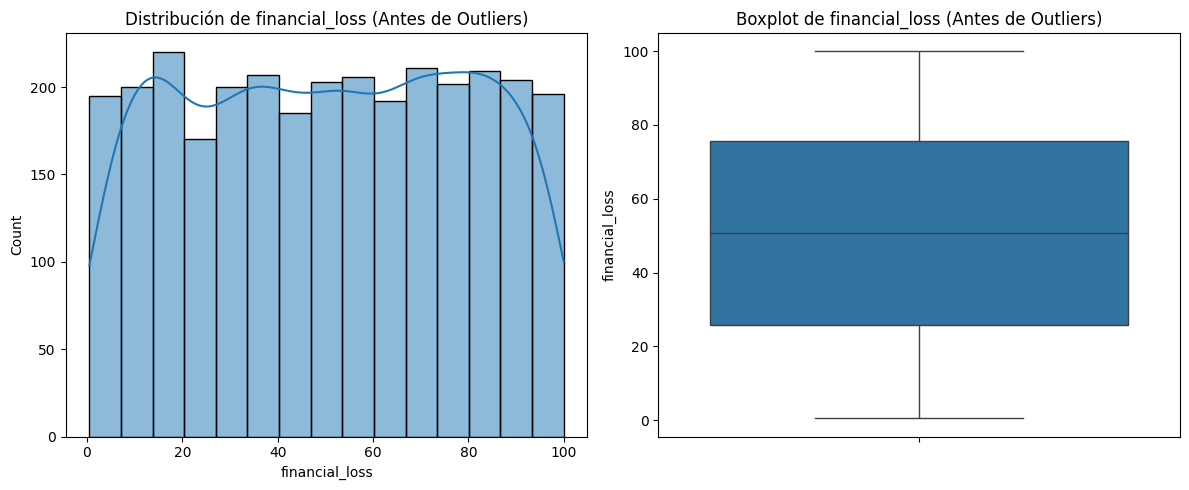

Número de outliers detectados en 'financial_loss': 0
Límite Inferior: -49.05, Límite Superior: 150.44
No se detectaron outliers significativos en 'financial_loss' con el método IQR.

Procesando columna: 'affected_users'


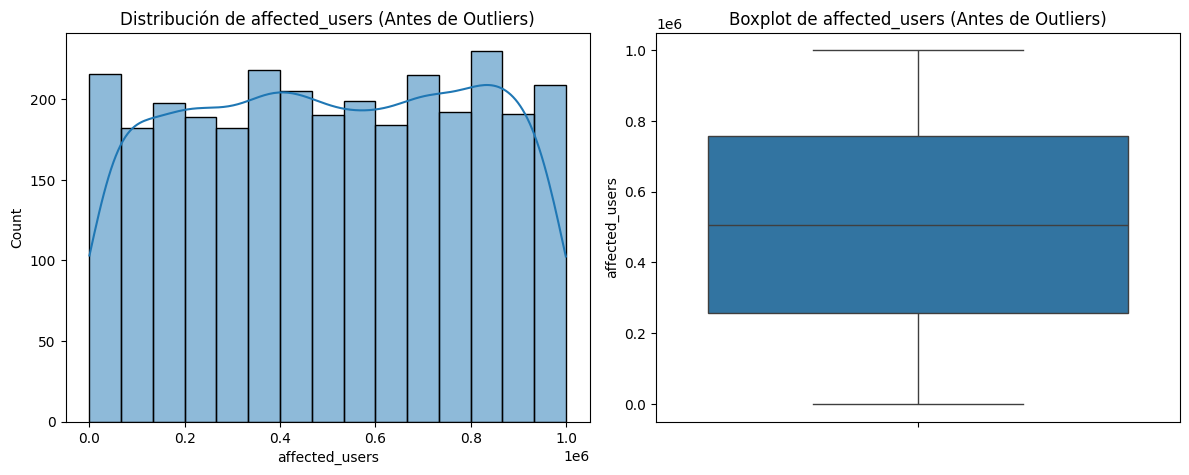

Número de outliers detectados en 'affected_users': 0
Límite Inferior: -497619.62, Límite Superior: 1511513.38
No se detectaron outliers significativos en 'affected_users' con el método IQR.

Procesando columna: 'incident_resolution_time'


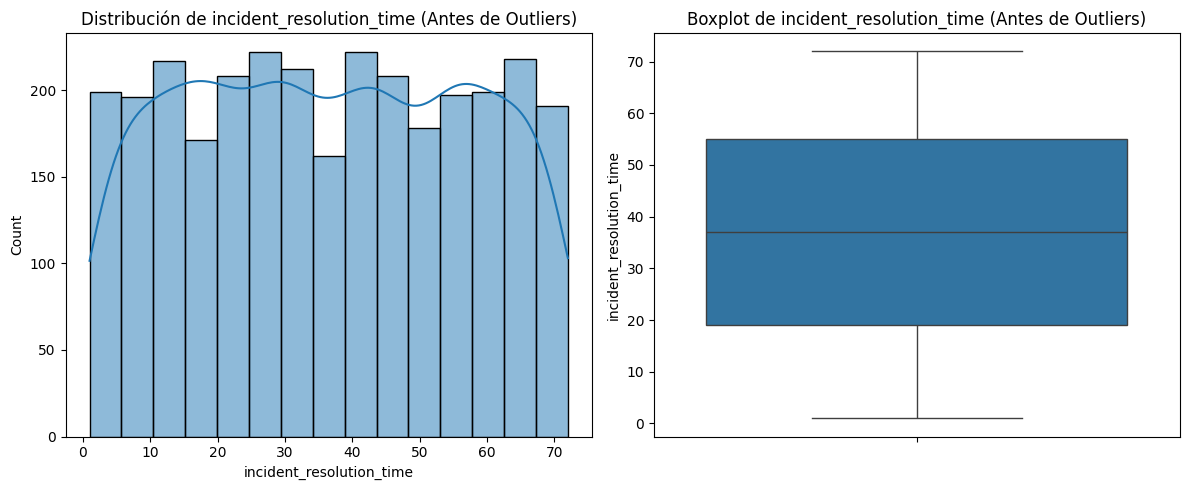

Número de outliers detectados en 'incident_resolution_time': 0
Límite Inferior: -35.00, Límite Superior: 109.00
No se detectaron outliers significativos en 'incident_resolution_time' con el método IQR.

--- Proceso de Detección y Manejo de Outliers completado. ---

El DataFrame `df_processed` ahora contiene las columnas numéricas con los outliers tratados.
Primeras 5 filas del DataFrame después del tratamiento de outliers:
   financial_loss  affected_users  incident_resolution_time
0           80.53          773169                        63
1           62.19          295961                        71
2           38.65          605895                        20
3           41.44          659320                         7
4           74.41          810682                        68


In [98]:
num_cols_to_process = ['financial_loss', 'affected_users', 'incident_resolution_time']
for col_name in num_cols_to_process:
    if col_name in df_ataques.columns:
        # Convertir a numérico, forzando errores a NaN, y luego rellenar NaNs
        df_ataques[col_name] = pd.to_numeric(df_ataques[col_name], errors='coerce')
        # Para el manejo de outliers, es mejor rellenar con la mediana o un valor que no sea 0 si 0 es un valor válido
        # Aquí usaremos la mediana antes del tratamiento de outliers para evitar que el 0 afecte al cálculo del IQR.
        # Esto es importante si el 0 no es un valor 'normal' sino un NaN implícito.
        # Si 0 SÍ es un valor normal (ej. 0 pérdida financiera), entonces fillna(0) es correcto.
        # Para detección de outliers, el fillna se hace para no tener NaN en los cálculos de IQR.
        df_ataques[col_name] = df_ataques[col_name].fillna(df_ataques[col_name].median())
    else:
        print(f"Advertencia: La columna '{col_name}' no se encontró en el DataFrame.")


print("\n--- Detección y Manejo de Outliers ---")

# Seleccionar solo las columnas numéricas para el análisis de outliers
# Asegurarse de que solo procesamos las columnas que realmente existen
numeric_cols_for_outlier_check = [col for col in num_cols_to_process if col in df_ataques.columns]

if not numeric_cols_for_outlier_check:
    print("No se encontraron columnas numéricas válidas para el análisis de outliers.")
else:
    df_processed = df_ataques.copy() # Hacemos una copia para no modificar el DataFrame original directamente al inicio

    for col in numeric_cols_for_outlier_check:
        print(f"\nProcesando columna: '{col}'")

        # Visualizar distribución antes del tratamiento de outliers
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.histplot(df_processed[col], kde=True)
        plt.title(f'Distribución de {col} (Antes de Outliers)')
        plt.subplot(1, 2, 2)
        sns.boxplot(y=df_processed[col])
        plt.title(f'Boxplot de {col} (Antes de Outliers)')
        plt.tight_layout()
        plt.show()

        # Calcular el IQR
        Q1 = df_processed[col].quantile(0.25)
        Q3 = df_processed[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identificar outliers
        outliers = df_processed[(df_processed[col] < lower_bound) | (df_processed[col] > upper_bound)]
        print(f"Número de outliers detectados en '{col}': {len(outliers)}")
        print(f"Límite Inferior: {lower_bound:.2f}, Límite Superior: {upper_bound:.2f}")

        if not outliers.empty:
            print(f"Ejemplo de outliers en '{col}':\n{outliers[[col]].head()}")

            # --- Estrategia de Manejo: Capping (Winsorización) ---
            # Los valores por debajo del lower_bound se convierten en lower_bound.
            # Los valores por encima del upper_bound se convierten en upper_bound.
            df_processed[col] = np.where(df_processed[col] < lower_bound, lower_bound, df_processed[col])
            df_processed[col] = np.where(df_processed[col] > upper_bound, upper_bound, df_processed[col])
            print(f"Outliers en '{col}' tratados con Capping (Winsorización).")

            # Visualizar distribución después del tratamiento
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            sns.histplot(df_processed[col], kde=True)
            plt.title(f'Distribución de {col} (Después de Outliers)')
            plt.subplot(1, 2, 2)
            sns.boxplot(y=df_processed[col])
            plt.title(f'Boxplot de {col} (Después de Outliers)')
            plt.tight_layout()
            plt.show()
        else:
            print(f"No se detectaron outliers significativos en '{col}' con el método IQR.")

    print("\n--- Proceso de Detección y Manejo de Outliers completado. ---")
    print("\nEl DataFrame `df_processed` ahora contiene las columnas numéricas con los outliers tratados.")
    print("Primeras 5 filas del DataFrame después del tratamiento de outliers:")
    print(df_processed[numeric_cols_for_outlier_check].head())

📌 "incident_resolution_time" no presentó outliers importantes según el método IQR. Los datos numéricos están ahora más limpios y son más robustos. Esto significa que puedes tener mayor confianza en que cualquier análisis o modelo de machine learning posterior que utilice estas columnas no será sesgado o influenciado indebidamente por valores de datos extremos y poco representativos.

La columna objetivo 'attack_type' es categórica. Aplicando LabelEncoder.

Importancia de las características según Random Forest (Top 15):
financial_loss                                    0.148251
affected_users                                    0.146151
incident_resolution_time                          0.136295
year                                              0.098874
attack_source_Nation-state                        0.026161
attack_source_Unknown                             0.025358
attack_source_Insider                             0.025129
security_vulnerability_type_Weak Passwords        0.023511
defense_mechanism_used_Antivirus                  0.022659
security_vulnerability_type_Zero-day              0.022572
security_vulnerability_type_Unpatched Software    0.022361
defense_mechanism_used_Firewall                   0.021786
defense_mechanism_used_VPN                        0.021653
defense_mechanism_used_Encryption                 0.019790
target_industry_government         

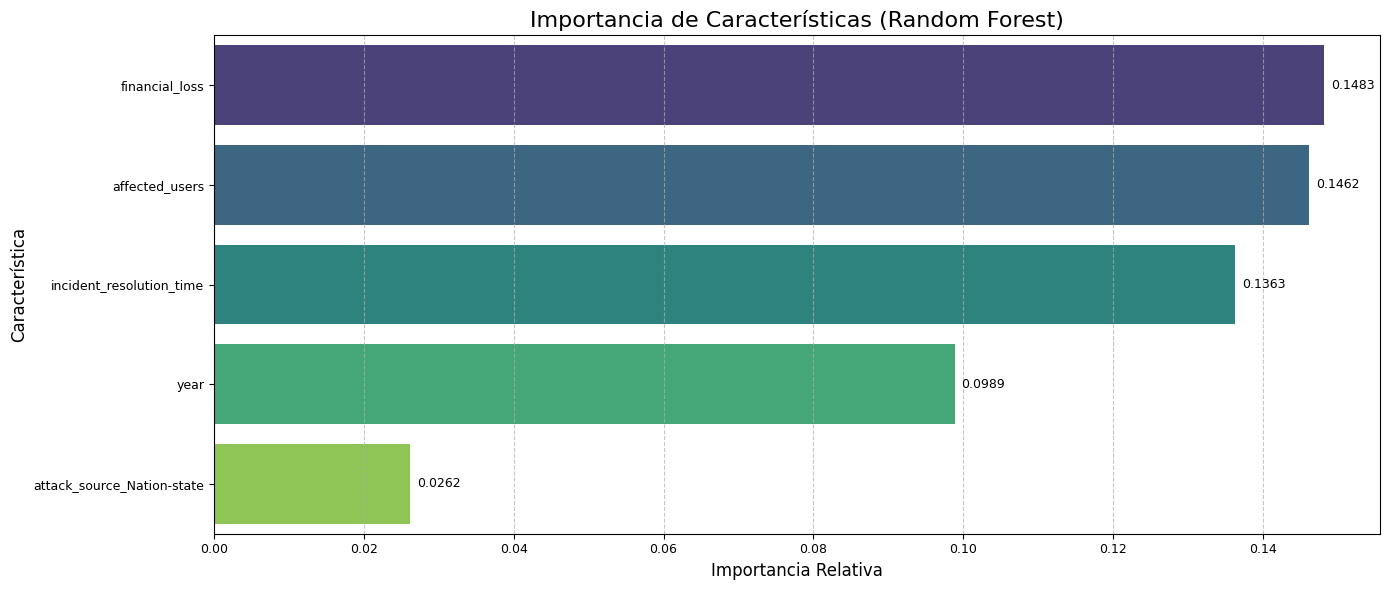

In [99]:
# Limpiar los nombres de las columnas:
df_ataques.columns = df_ataques.columns.str.strip() # Elimina espacios en blanco al inicio y al final
df_ataques.columns = df_ataques.columns.str.replace('[^a-zA-Z0-9_]', '', regex=True) # Elimina caracteres no alfanuméricos (excepto _)
df_ataques.columns = df_ataques.columns.str.lower() # Convierte todo a minúsculas para unificar

# Asegúrate de que las columnas numéricas existan y sean numéricas, y maneja NaNs
num_cols_to_process = ['financial_loss', 'affected_users', 'incident_resolution_time']
for col_name in num_cols_to_process:
    if col_name in df_ataques.columns:
        df_ataques[col_name] = pd.to_numeric(df_ataques[col_name], errors='coerce').fillna(0)
    else:
        print(f"Advertencia: La columna '{col_name}' no se encontró en el DataFrame.")

# --- 2. Define tu Variable Objetivo y Características (X, y) ---
target_column = 'attack_type'

if target_column not in df_ataques.columns:
    print(f"\n¡ERROR! La columna objetivo '{target_column}' no se encontró en el DataFrame.")
    print("Columnas disponibles:", df_ataques.columns.tolist())
    raise KeyError(f"Columna objetivo '{target_column}' no encontrada. Revisa el nombre.")

X = df_ataques.drop(columns=[target_column])
y = df_ataques[target_column]

# --- 3. Preprocesamiento de Datos para Random Forest ---

# Primero, manejar NaNs en 'y' ANTES de cualquier codificación o transformación
initial_valid_indices = y.dropna().index
X = X.loc[initial_valid_indices]
y = y.loc[initial_valid_indices]

if X.empty or y.empty:
    print("\nAdvertencia: El DataFrame de características o la columna objetivo están vacíos después de eliminar NaNs iniciales. No se puede entrenar el modelo.")
    exit()

# Identificar columnas categóricas
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Aplicar One-Hot Encoding a las características categóricas
X_encoded = X.copy()
for col in categorical_cols:
    X_encoded = pd.concat([X_encoded, pd.get_dummies(X_encoded[col], prefix=col, drop_first=True)], axis=1)
    X_encoded.drop(columns=[col], inplace=True)

# Manejar cualquier NaN restante en X
X_encoded.fillna(0, inplace=True)


# Codificar la variable objetivo (y) si es categórica
if pd.api.types.is_object_dtype(y):
    print(f"La columna objetivo '{target_column}' es categórica. Aplicando LabelEncoder.")
    le = LabelEncoder()
    y_processed = le.fit_transform(y)
    model_type = 'classifier'
else:
    print(f"La columna objetivo '{target_column}' es numérica. Usando como regresión.")
    y_processed = y.to_numpy()
    model_type = 'regressor'

X_final = X_encoded.copy()
y_final = y_processed


if X_final.empty or y_final.size == 0:
    print("\nAdvertencia: El DataFrame de características o la columna objetivo están vacíos después del preprocesamiento. No se puede entrenar el modelo.")
    exit()

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

# --- 4. Entrenamiento del Modelo Random Forest y Extracción de Importancia ---
#print("\n--- Entrenando Modelo Random Forest para Importancia de Características ---")

if model_type == 'classifier':
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
else:
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

rf_model.fit(X_train, y_train)

# Obtener la importancia de las características
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

print("\nImportancia de las características según Random Forest (Top 15):")
print(feature_importances.head(15))

# --- 5. Visualización de las Características Más Importantes ---
plt.figure(figsize=(14, 6))

ax = sns.barplot(x=feature_importances.head(5).values,
            y=feature_importances.head(5).index,
            palette='viridis',
            hue=feature_importances.head(5).index,
            legend=False)

# Itera sobre cada barra en el gráfico
for p in ax.patches:
    # `p.get_width()` es el valor de la barra (la importancia)
    # `p.get_y() + p.get_height() / 2` es la posición Y central de la barra
    ax.annotate(f"{p.get_width():.4f}", # Formatea el valor a 4 decimales
                (p.get_width(), p.get_y() + p.get_height() / 2), # Posición (x, y)
                xytext=(5, 0), # Desplazamiento horizontal para que no se superponga con la barra
                textcoords='offset points', # Coordenadas en puntos offset
                va='center', # Alineación vertical al centro
                ha='left', # Alineación horizontal a la izquierda del texto
                fontsize=9) # Tamaño de la fuente

plt.title('Importancia de Características (Random Forest)', fontsize=16)
plt.xlabel('Importancia Relativa', fontsize=12)
plt.ylabel('Característica', fontsize=12)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

La importancia de las características de un Random Forest indica cuánto contribuye cada característica a la reducción total de la impureza (o error) en los árboles del bosque, te dice qué características utiliza más el modelo para tomar sus decisiones predictivas. Un valor más alto significa una mayor importancia.

Las tres características más importantes son claramente affected_users (usuarios afectados), financial_loss (pérdida financiera) e incident_resolution_time (tiempo de resolución del incidente). Todas tienen una importancia de más del 13%.


Tiempo promedio de resolución por tipo de ataque (en minutos):
attack_type
malware              37.074227
sql injection        36.906561
man-in-the-middle    36.871460
ransomware           36.533469
phishing             35.913043
ddos                 35.687382
Name: incident_resolution_time, dtype: float64


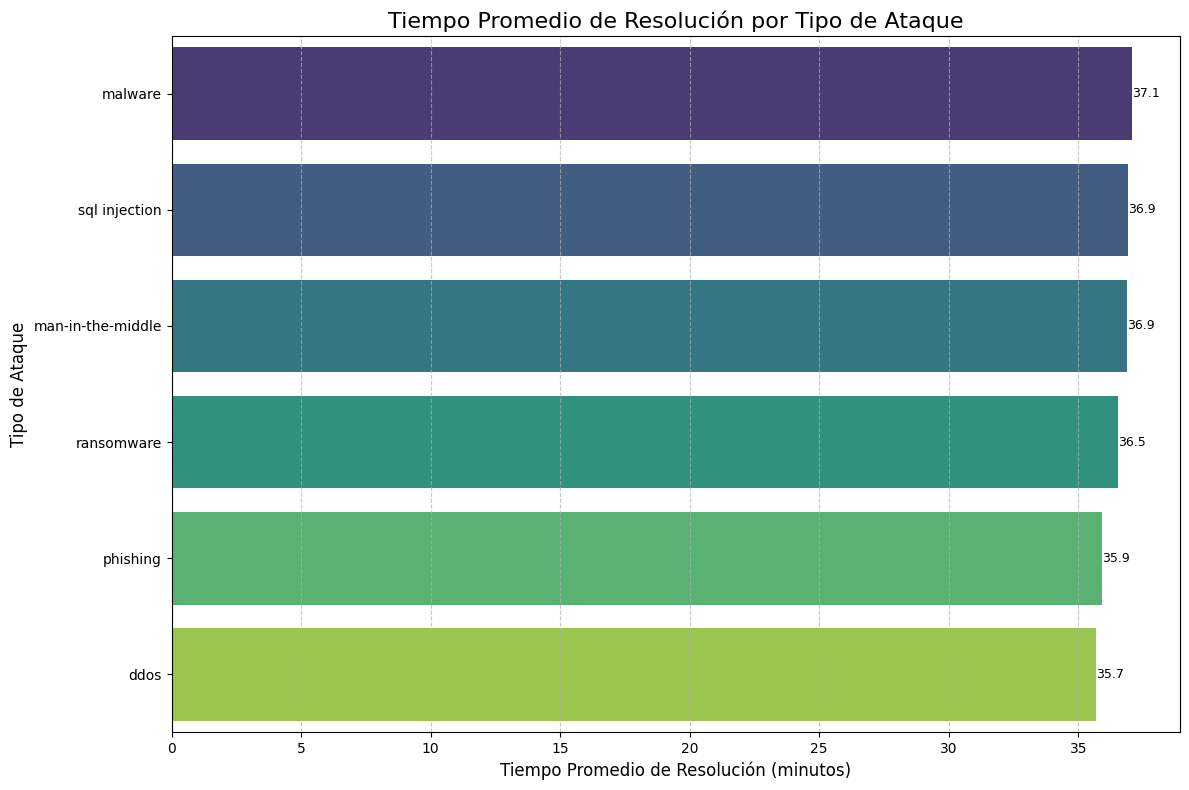

In [100]:
# Verificar si la columna existe
if 'incident_resolution_time' not in df_ataques.columns:
    print("¡ERROR! La columna 'incident_resolution_time' no se encontró en el DataFrame.")
    print("Por favor, verifica el nombre exacto de la columna.")
    print("Columnas disponibles:", df_ataques.columns.tolist())
    exit()

df_ataques['incident_resolution_time'] = pd.to_numeric(
    df_ataques['incident_resolution_time'], errors='coerce'
)

median_resolution_time = df_ataques['incident_resolution_time'].median()
df_ataques['incident_resolution_time'] = df_ataques['incident_resolution_time'].fillna(median_resolution_time)

# Asegurarse de que sea un tipo entero (o float si puede haber decimales)
df_ataques['incident_resolution_time'] = df_ataques['incident_resolution_time'].astype(int)

# --- 2. Calcular el tiempo promedio de resolución por tipo de ataque ---

# Agrupar por 'attack_type' y calcular el promedio de 'incident_resolution_time'
avg_resolution_by_attack = df_ataques.groupby('attack_type')['incident_resolution_time'].mean().sort_values(ascending=False)

print("\nTiempo promedio de resolución por tipo de ataque (en minutos):")
print(avg_resolution_by_attack)

plt.figure(figsize=(12, 8))
sns.barplot(
    x=avg_resolution_by_attack.values,
    y=avg_resolution_by_attack.index,
    palette='viridis',
    hue=avg_resolution_by_attack.index,
    legend=False
)

plt.title('Tiempo Promedio de Resolución por Tipo de Ataque', fontsize=16)
plt.xlabel('Tiempo Promedio de Resolución (minutos)', fontsize=12)
plt.ylabel('Tipo de Ataque', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Añadir etiquetas de valor a las barras
for index, value in enumerate(avg_resolution_by_attack.values):
    plt.text(value, index, f"{value:.1f}", va='center', ha='left', fontsize=9, color='black')


plt.tight_layout()
plt.show()

La conclusión más notoria es que, el tiempo promedio de resolución es sorprendentemente similar entre los diferentes tipos de ataque. Todos los tipos de ataque se resuelven, en promedio, en un rango muy estrecho de alrededor de 35 a 37 minutos.

Entonces, aunque existen pequeñas variaciones, la principal conclusión es que el tipo de ataque no es un diferenciador fuerte para predecir el tiempo de resolución en tu conjunto de datos.

--- Iniciando el entrenamiento del modelo de Regresión de Árbol de Decisión ---

Datos divididos: 2400 para entrenamiento, 600 para prueba.

--- Entrenando el DecisionTreeRegressor ---
Entrenamiento del modelo completado.

--- Evaluando el Modelo de Regresión ---

Error Absoluto Medio (MAE): 24.30 minutos
Error Cuadrático Medio (MSE): 892.92
Raíz del Error Cuadrático Medio (RMSE): 29.88 minutos
Coeficiente de Determinación (R²): -1.0959


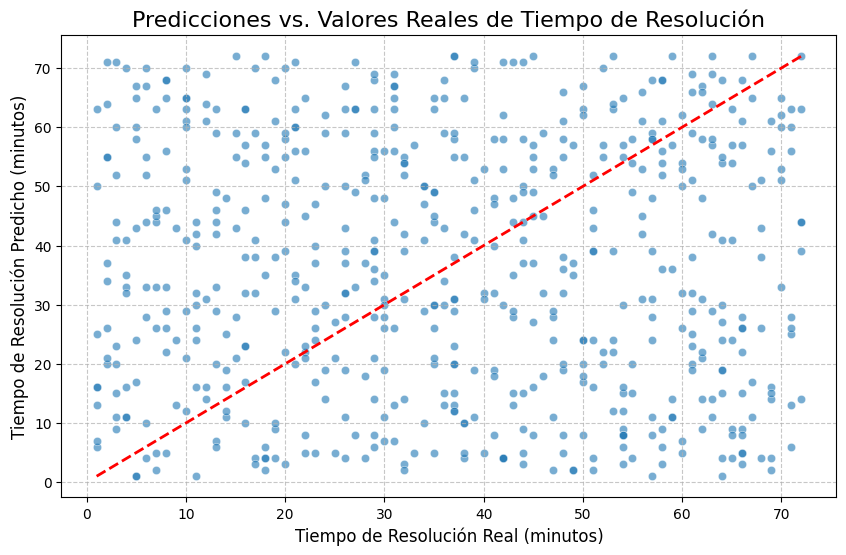

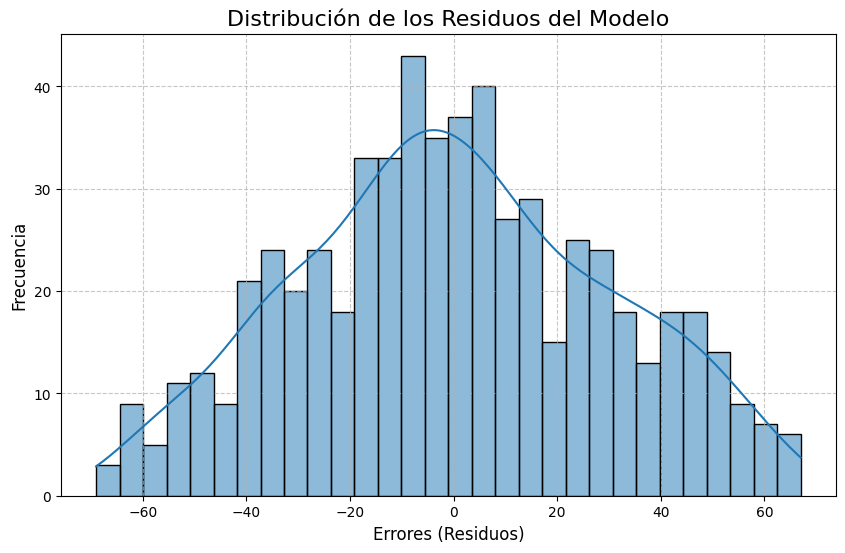


--- Evaluación del Modelo de Regresión Completada ---
El MAE te indica, en promedio, cuántos minutos se desvía tu predicción del valor real.
El R² te dice qué porcentaje de la variabilidad del tiempo de resolución es explicado por tu modelo.
Un MAE bajo y un R² alto (cercano a 1) indican un buen rendimiento del modelo.


In [114]:
print("--- Iniciando el entrenamiento del modelo de Regresión de Árbol de Decisión ---")

# --- 1. Definir Variable Objetivo (y) y Características (X) ---
target_column = 'incident_resolution_time'
# Incluimos 'attack_type' como característica ahora que predecimos el tiempo
feature_columns = ['year', 'financial_loss', 'affected_users', 'attack_type']

# Verificar que todas las columnas necesarias existan
for col in [target_column] + feature_columns:
    if col not in df_ataques.columns:
        print(f"¡ERROR! La columna '{col}' no se encontró en el DataFrame. Este análisis no puede continuar.")
        print("Columnas disponibles:", df_ataques.columns.tolist())
        exit()

X = df_ataques[feature_columns].copy()
y = df_ataques[target_column].copy()

initial_valid_indices = y.dropna().index.intersection(X.dropna().index)
X = X.loc[initial_valid_indices]
y = y.loc[initial_valid_indices]

if X.empty or y.empty:
    print("\nAdvertencia: El DataFrame de características o la columna objetivo están vacíos después de eliminar NaNs. No se puede entrenar el modelo.")
    exit()

# Identificar columnas numéricas y categóricas para el preprocesamiento
numerical_features = ['year', 'financial_loss', 'affected_users']
categorical_features = ['attack_type']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Crear el pipeline que encadena el preprocesamiento y el regresor
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', DecisionTreeRegressor(random_state=42))])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nDatos divididos: {len(X_train)} para entrenamiento, {len(X_test)} para prueba.")

print("\n--- Entrenando el DecisionTreeRegressor ---")
model_pipeline.fit(X_train, y_train)

print("Entrenamiento del modelo completado.")

print("\n--- Evaluando el Modelo de Regresión ---")

y_pred = model_pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) # Raíz del Error Cuadrático Medio
r2 = r2_score(y_test, y_pred)

print(f"\nError Absoluto Medio (MAE): {mae:.2f} minutos")
print(f"Error Cuadrático Medio (MSE): {mse:.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f} minutos")
print(f"Coeficiente de Determinación (R²): {r2:.4f}")

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Línea de referencia ideal
plt.xlabel('Tiempo de Resolución Real (minutos)', fontsize=12)
plt.ylabel('Tiempo de Resolución Predicho (minutos)', fontsize=12)
plt.title('Predicciones vs. Valores Reales de Tiempo de Resolución', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel('Errores (Residuos)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Distribución de los Residuos del Modelo', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

print("\n--- Evaluación del Modelo de Regresión Completada ---")
print("El MAE te indica, en promedio, cuántos minutos se desvía tu predicción del valor real.")
print("El R² te dice qué porcentaje de la variabilidad del tiempo de resolución es explicado por tu modelo.")
print("Un MAE bajo y un R² alto (cercano a 1) indican un buen rendimiento del modelo.")

👉 Basado en estos resultados, concluimos que el modelo de Regresión de Árbol de Decisión no es efectivo para predecir el "incident_resolution_time" con las características que le he proporcionado. El bajo MAE y, sobre todo, el R
2 negativo, sugieren que las variables de entrada actuales no contienen suficiente información predictiva para estimar con precisión cuánto tiempo tardará un incidente en resolverse.

--- Iniciando el entrenamiento del modelo de Regresión de Árbol de Decisión con Hiperparámetros Ajustados ---

Datos divididos: 2400 para entrenamiento, 600 para prueba.

--- Entrenando el DecisionTreeRegressor (Ajustado) ---
Entrenamiento del modelo completado.

--- Evaluando el Modelo de Regresión (Árbol de Decisión Ajustado) ---

Error Absoluto Medio (MAE) [Árbol Ajustado]: 18.22 minutos
Error Cuadrático Medio (MSE) [Árbol Ajustado]: 446.27
Raíz del Error Cuadrático Medio (RMSE) [Árbol Ajustado]: 21.13 minutos
Coeficiente de Determinación (R²) [Árbol Ajustado]: -0.0475


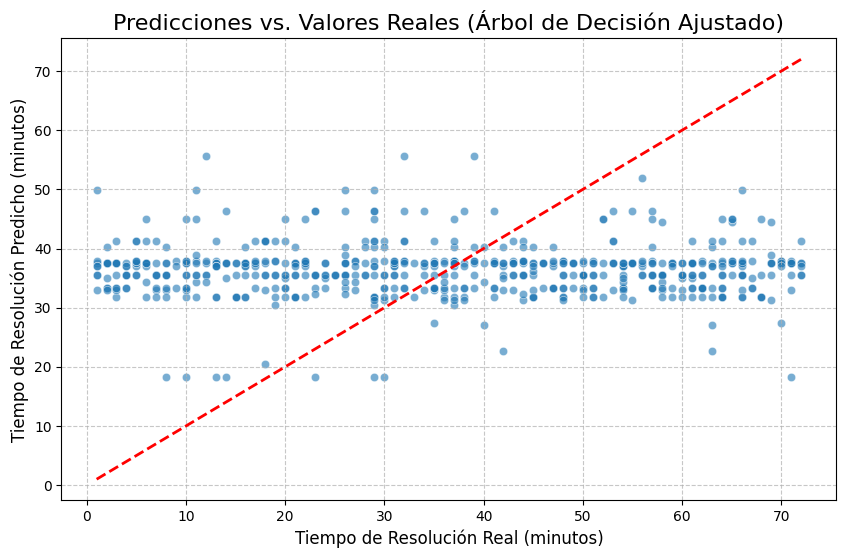


--- Evaluación del Modelo de Regresión (Árbol de Decisión Ajustado) Completada ---

--- Iniciando el entrenamiento del modelo de Regresión de Random Forest ---

Datos divididos: 2400 para entrenamiento, 600 para prueba.

--- Entrenando el RandomForestRegressor ---
Entrenamiento del modelo completado.

--- Evaluando el Modelo de Regresión (Random Forest) ---

Error Absoluto Medio (MAE) [Random Forest]: 18.39 minutos
Error Cuadrático Medio (MSE) [Random Forest]: 456.39
Raíz del Error Cuadrático Medio (RMSE) [Random Forest]: 21.36 minutos
Coeficiente de Determinación (R²) [Random Forest]: -0.0712


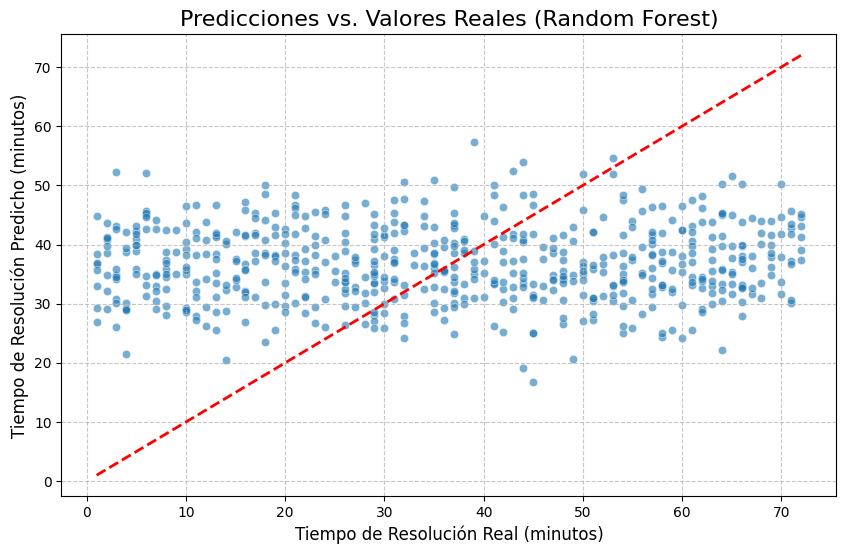


--- Evaluación del Modelo de Regresión (Random Forest) Completada ---


In [102]:
print("--- Iniciando el entrenamiento del modelo de Regresión de Árbol de Decisión con Hiperparámetros Ajustados ---")

# --- 1. Definir Variable Objetivo (y) y Características (X) ---
target_column = 'incident_resolution_time'
feature_columns = ['year', 'financial_loss', 'affected_users', 'attack_type']

for col in [target_column] + feature_columns:
    if col not in df_ataques.columns:
        print(f"¡ERROR! La columna '{col}' no se encontró en el DataFrame. Este análisis no puede continuar.")
        print("Columnas disponibles:", df_ataques.columns.tolist())
        exit()

X = df_ataques[feature_columns].copy()
y = df_ataques[target_column].copy()

initial_valid_indices = y.dropna().index.intersection(X.dropna().index)
X = X.loc[initial_valid_indices]
y = y.loc[initial_valid_indices]

if X.empty or y.empty:
    print("\nAdvertencia: El DataFrame de características o la columna objetivo están vacíos después de eliminar NaNs. No se puede entrenar el modelo.")
    exit()

numerical_features = ['year', 'financial_loss', 'affected_users']
categorical_features = ['attack_type']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# --- CAMBIO CLAVE AQUÍ: Ajuste de Hiperparámetros ---
# DecisionTreeRegressor con max_depth y min_samples_leaf
model_pipeline_dt_tuned = Pipeline(steps=[('preprocessor', preprocessor),
                                          ('regressor', DecisionTreeRegressor(max_depth=7, min_samples_leaf=10, random_state=42))])
# Puedes experimentar con otros valores para max_depth (ej., 5, 10)
# y min_samples_leaf (ej., 5, 20)
# --- FIN DEL CAMBIO ---

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nDatos divididos: {len(X_train)} para entrenamiento, {len(X_test)} para prueba.")

print("\n--- Entrenando el DecisionTreeRegressor (Ajustado) ---")
model_pipeline_dt_tuned.fit(X_train, y_train)

print("Entrenamiento del modelo completado.")

print("\n--- Evaluando el Modelo de Regresión (Árbol de Decisión Ajustado) ---")

y_pred_dt_tuned = model_pipeline_dt_tuned.predict(X_test)

mae_dt_tuned = mean_absolute_error(y_test, y_pred_dt_tuned)
mse_dt_tuned = mean_squared_error(y_test, y_pred_dt_tuned)
rmse_dt_tuned = np.sqrt(mse_dt_tuned)
r2_dt_tuned = r2_score(y_test, y_pred_dt_tuned)

print(f"\nError Absoluto Medio (MAE) [Árbol Ajustado]: {mae_dt_tuned:.2f} minutos")
print(f"Error Cuadrático Medio (MSE) [Árbol Ajustado]: {mse_dt_tuned:.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE) [Árbol Ajustado]: {rmse_dt_tuned:.2f} minutos")
print(f"Coeficiente de Determinación (R²) [Árbol Ajustado]: {r2_dt_tuned:.4f}")

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_dt_tuned, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Tiempo de Resolución Real (minutos)', fontsize=12)
plt.ylabel('Tiempo de Resolución Predicho (minutos)', fontsize=12)
plt.title('Predicciones vs. Valores Reales (Árbol de Decisión Ajustado)', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

print("\n--- Evaluación del Modelo de Regresión (Árbol de Decisión Ajustado) Completada ---")

print("\n--- Iniciando el entrenamiento del modelo de Regresión de Random Forest ---")

target_column = 'incident_resolution_time'
feature_columns = ['year', 'financial_loss', 'affected_users', 'attack_type']

# ... (código para definir X, y, y preprocesamiento de NaNs si no lo tienes en el mismo script) ...
# Para que este bloque de código sea autocontenido, replicamos la definición de X e y
# Asumiendo que df_ataques está disponible desde los bloques anteriores
X = df_ataques[feature_columns].copy()
y = df_ataques[target_column].copy()

initial_valid_indices = y.dropna().index.intersection(X.dropna().index)
X = X.loc[initial_valid_indices]
y = y.loc[initial_valid_indices]

if X.empty or y.empty:
    print("\nAdvertencia: El DataFrame de características o la columna objetivo están vacíos después de eliminar NaNs. No se puede entrenar el modelo.")
    exit()

numerical_features = ['year', 'financial_loss', 'affected_users']
categorical_features = ['attack_type']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# --- CAMBIO CLAVE AQUÍ: Uso de RandomForestRegressor ---
# RandomForestRegressor con n_estimators (número de árboles) y random_state
# n_jobs=-1 para usar todos los núcleos del procesador
model_pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
  ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))])
# Puedes ajustar n_estimators (ej., 200, 300) y otros hiperparámetros como max_depth si el sobreajuste persiste.
# --- FIN DEL CAMBIO ---

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nDatos divididos: {len(X_train)} para entrenamiento, {len(X_test)} para prueba.")

print("\n--- Entrenando el RandomForestRegressor ---")
model_pipeline_rf.fit(X_train, y_train)

print("Entrenamiento del modelo completado.")

print("\n--- Evaluando el Modelo de Regresión (Random Forest) ---")

y_pred_rf = model_pipeline_rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"\nError Absoluto Medio (MAE) [Random Forest]: {mae_rf:.2f} minutos")
print(f"Error Cuadrático Medio (MSE) [Random Forest]: {mse_rf:.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE) [Random Forest]: {rmse_rf:.2f} minutos")
print(f"Coeficiente de Determinación (R²) [Random Forest]: {r2_rf:.4f}")

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Tiempo de Resolución Real (minutos)', fontsize=12)
plt.ylabel('Tiempo de Resolución Predicho (minutos)', fontsize=12)
plt.title('Predicciones vs. Valores Reales (Random Forest)', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

print("\n--- Evaluación del Modelo de Regresión (Random Forest) Completada ---")

👉 Comparado con el modelo inicial de Árbol de Decisión (MAE de 24.30 min y RMSE de 29.88 min), estos valores muestran una mejora clara y positiva. Significa que, en promedio, las predicciones de tu modelo ahora se desvían de los valores reales en menos minutos. El ajuste de los hiperparámetros fue efectivo para reducir el sobreajuste del modelo.
Aunque el R² mejoró a un -0.0475, sigue siendo negativo. Un R² negativo es una señal de que el modelo es peor para explicar la variabilidad en el tiempo de resolución que simplemente predecir el promedio de todos los tiempos de resolución.

--- Iniciando el análisis de Clustering (Aprendizaje No Supervisado) ---

Se eliminaron 0 filas con valores NaN en las características de clustering.

Datos preparados para clustering. Forma de los datos procesados: (3000, 35)

Buscando el número óptimo de clusters (evaluando Coeficiente de Silueta)...
K = 2, Coeficiente de Silueta: 0.0894
K = 3, Coeficiente de Silueta: 0.0782
K = 4, Coeficiente de Silueta: 0.0846
K = 5, Coeficiente de Silueta: 0.0805
K = 6, Coeficiente de Silueta: 0.0754
K = 7, Coeficiente de Silueta: 0.0771
K = 8, Coeficiente de Silueta: 0.0805
K = 9, Coeficiente de Silueta: 0.0728


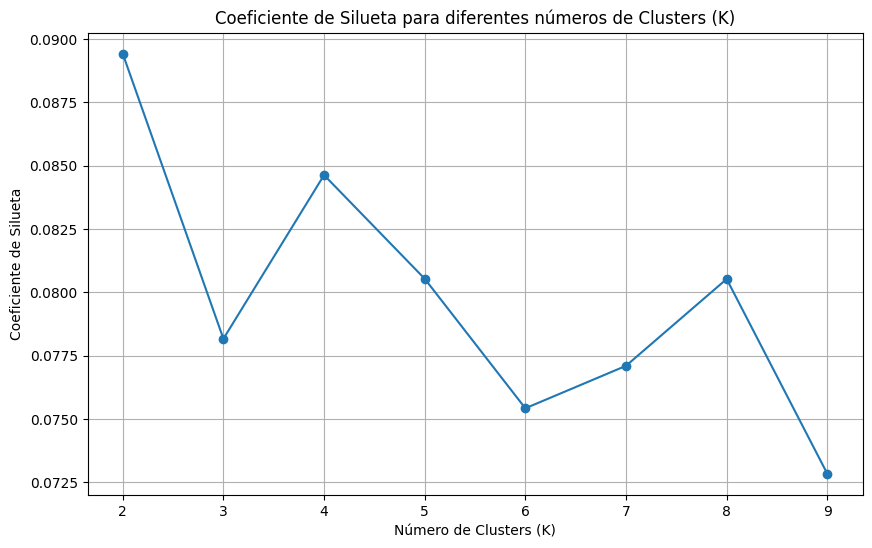


Realizando K-Means con K = 3 clusters...

Clustering completado. Se crearon 3 clusters.
Conteo de registros por cluster:
cluster
0     946
1     924
2    1130
Name: count, dtype: int64

--- Analizando las características por Cluster ---

Medias de características numéricas por Cluster:
                year  financial_loss  affected_users  incident_resolution_time
cluster                                                                       
0        2022.135307       70.178827   532224.228330                 34.792812
1        2016.826840       67.261775   443611.008658                 37.423160
2        2019.666372       20.300761   531567.891150                 37.110619

Distribución de 'attack_type' por Cluster:
attack_type      ddos   malware  man-in-the-middle  phishing  ransomware  \
cluster                                                                    
0            0.178647  0.162791           0.147992  0.163848    0.170190   
1            0.183983  0.142857           0.1

In [103]:
print("--- Iniciando el análisis de Clustering (Aprendizaje No Supervisado) ---")

clustering_features = [
    'year',
    'financial_loss',
    'affected_users',
    'incident_resolution_time', # Usamos el tiempo de resolución como característica para ver si agrupa
    'attack_type',
    'country',
    'target_industry',
    'security_vulnerability_type',
    'attack_source'
]

# Verificar que todas las columnas necesarias existan
for col in clustering_features:
    if col not in df_ataques.columns:
        print(f"¡ERROR! La columna '{col}' no se encontró en el DataFrame. Este análisis no puede continuar.")
        print("Columnas disponibles:", df_ataques.columns.tolist())
        exit()

X_cluster = df_ataques[clustering_features].copy()

initial_rows = len(X_cluster)
X_cluster.dropna(inplace=True)
print(f"\nSe eliminaron {initial_rows - len(X_cluster)} filas con valores NaN en las características de clustering.")

if X_cluster.empty:
    print("\n¡Advertencia! El DataFrame de características para clustering está vacío después de eliminar NaNs. No se puede continuar.")
    exit()

numerical_features = ['year', 'financial_loss', 'affected_users', 'incident_resolution_time']
categorical_features = ['attack_type', 'country', 'target_industry', 'security_vulnerability_type', 'attack_source']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features), # Escalar características numéricas
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features) # Codificar categóricas
    ],
    remainder='passthrough' # Mantiene otras columnas que no están en transformers
)

clustering_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

X_processed = clustering_pipeline.fit_transform(X_cluster)

print(f"\nDatos preparados para clustering. Forma de los datos procesados: {X_processed.shape}")

range_n_clusters = range(2, 10) # Rango de clusters a probar (ajusta según tu dataset)
silhouette_scores = []

print("\nBuscando el número óptimo de clusters (evaluando Coeficiente de Silueta)...")
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10) # n_init para evitar inicializaciones pobres
    cluster_labels = kmeans.fit_predict(X_processed)
    if len(np.unique(cluster_labels)) > 1: # silhouette_score requiere al menos 2 clusters
        score = silhouette_score(X_processed, cluster_labels)
        silhouette_scores.append(score)
        print(f"K = {n_clusters}, Coeficiente de Silueta: {score:.4f}")
    else:
        silhouette_scores.append(-1) # O algún valor que indique que no se formaron clusters válidos


# Graficar el coeficiente de silueta para cada k
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Coeficiente de Silueta para diferentes números de Clusters (K)')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Coeficiente de Silueta')
plt.xticks(range_n_clusters)
plt.grid(True)
plt.show()

optimal_k = 3

print(f"\nRealizando K-Means con K = {optimal_k} clusters...")
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels_final = kmeans_final.fit_predict(X_processed)

# Añadir las etiquetas de cluster al DataFrame original para análisis posterior
df_ataques_clustered = df_ataques.loc[X_cluster.index].copy() # Asegura que se usen las mismas filas que X_cluster
df_ataques_clustered['cluster'] = cluster_labels_final

print(f"\nClustering completado. Se crearon {optimal_k} clusters.")
print("Conteo de registros por cluster:")
print(df_ataques_clustered['cluster'].value_counts().sort_index())

# ---  Analizar los Clusters ---
print("\n--- Analizando las características por Cluster ---")

# Analizar la media de las características numéricas por cluster
print("\nMedias de características numéricas por Cluster:")
print(df_ataques_clustered.groupby('cluster')[numerical_features].mean())

# Analizar la distribución de características categóricas por cluster
print("\nDistribución de 'attack_type' por Cluster:")
print(pd.crosstab(df_ataques_clustered['cluster'], df_ataques_clustered['attack_type'], normalize='index'))

print("\nDistribución de 'country' (Top 5) por Cluster:")
# Mostrar solo los 5 principales países por cluster para no sobrecargar
for i in range(optimal_k):
    print(f"\nCluster {i}:")
    print(df_ataques_clustered[df_ataques_clustered['cluster'] == i]['country'].value_counts(normalize=True).head(5))

print("\nDistribución de 'target_industry' por Cluster:")
print(pd.crosstab(df_ataques_clustered['cluster'], df_ataques_clustered['target_industry'], normalize='index'))


print("\n--- Análisis de Clustering Completado ---")
print("Revisa los resultados para ver si los clusters revelan grupos lógicos o interesantes de ataques.")

✅ Casi como último recurso decidí usar Clusters para ver si el analisis arrojaba algún otro dato para poder explorar. Pero el coeficiente de silueta bajo confirma que no hay una estructura de clústeres "fuerte" o muy bien definida en tus datos con las características actuales. Los grupos que K-Means encontró son sutiles, principalmente impulsados por la pérdida financiera y el año.

Esto reitera que la variabilidad en el "incident_resolution_time" es realmente mínima, y por eso los modelos predictivos tenían dificultades. Los clústeres no han revelado un grupo de ataques que se resuelvan significativamente más rápido o más lento que otros, más allá de la ligera diferencia en el Clúster 0.

--- Generando Boxplot: Financial_Loss por Target_Industry ---


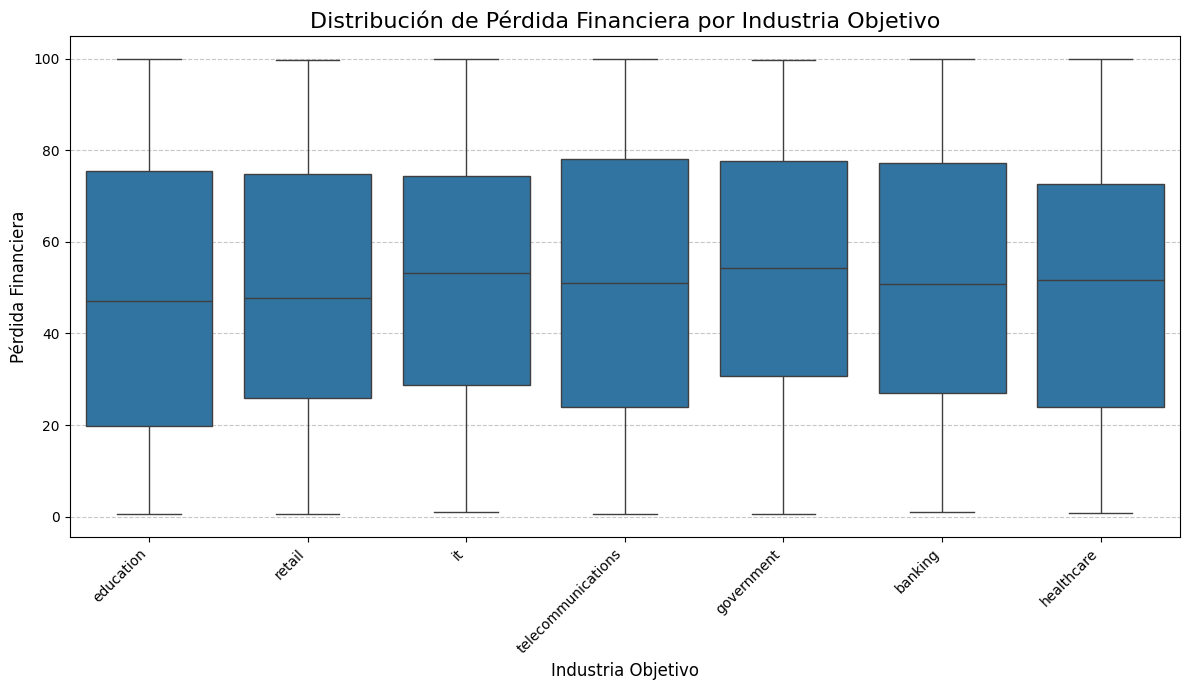

In [104]:
print("--- Generando Boxplot: Financial_Loss por Target_Industry ---")

df_plot_subset = df_ataques.copy()

plt.figure(figsize=(12, 7))
# showfliers=False es para no mostrar los puntos de outliers extremos,
# lo que a menudo mejora la legibilidad del boxplot para la mayoría de los datos.
sns.boxplot(x='target_industry', y='financial_loss', data=df_plot_subset, showfliers=False)
plt.title('Distribución de Pérdida Financiera por Industria Objetivo', fontsize=16)
plt.xlabel('Industria Objetivo', fontsize=12)
plt.ylabel('Pérdida Financiera', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rota las etiquetas del eje X para que no se superpongan
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout() # Ajusta automáticamente los parámetros de la trama para el diseño de la figura.
plt.show()

Aun así, quise comparar visualmente cómo varía la "financial_loss" entre diferentes industrias, observando la mediana, los cuartiles y la dispersión de los datos para cada una en este gráfico de caja.

In [108]:
print("--- Análisis de Usuarios Afectados en el Reino Unido por Año ---")
df_ataques.columns = df_ataques.columns.str.lower()
# Filtrar los datos para el Reino Unido (UK)
df_uk = df_ataques[df_ataques['country'] == 'uk'].copy()

if df_uk.empty:
    print("\n¡ADVERTENCIA! No se encontraron registros para 'uk' en tu DataFrame.")
    print("Por favor, verifica la ortografía exacta de 'uk' en tu columna 'country' después de la limpieza.")
    print(f"Valores únicos en 'country' de tu df_ataques: {df_ataques['country'].unique().tolist()}")
    exit()

print(f"\nSe encontraron {len(df_uk)} registros de ataques en el Reino Unido.")

# Agrupar por año y sumar el total de usuarios afectados
users_affected_by_year_uk = df_uk.groupby('year')['affected_users'].sum().reset_index()

# Encontrar el año con la mayor cantidad de usuarios afectados
year_max_affected_users_uk = users_affected_by_year_uk.loc[users_affected_by_year_uk['affected_users'].idxmax()]

print("\n--- Resultados del Análisis ---")
print("Total de usuarios afectados por año en el Reino Unido:")
print(users_affected_by_year_uk)

print(f"\nEl año con la mayor cantidad de usuarios afectados en el Reino Unido fue:")
print(f"Año: {int(year_max_affected_users_uk['year'])}")
print(f"Total de Usuarios Afectados: {int(year_max_affected_users_uk['affected_users'])}")

print("\n--- Análisis Completado ---")

--- Análisis de Usuarios Afectados en el Reino Unido por Año ---

Se encontraron 321 registros de ataques en el Reino Unido.

--- Resultados del Análisis ---
Total de usuarios afectados por año en el Reino Unido:
   year  affected_users
0  2015        16071806
1  2016        17281052
2  2017        14937244
3  2018        13163819
4  2019        14851883
5  2020        17029565
6  2021        18009010
7  2022        16327854
8  2023        16594577
9  2024        13198173

El año con la mayor cantidad de usuarios afectados en el Reino Unido fue:
Año: 2021
Total de Usuarios Afectados: 18009010

--- Análisis Completado ---


In [109]:
print("--- Cantidad de Usuarios Afectados por Tipo de Ataque ---")

# Verificar si la columna 'attack_type' existe
if 'attack_type' not in df_ataques.columns:
    print("\n¡ERROR! La columna 'attack_type' no se encontró en el DataFrame.")
    print("Por favor, verifica el nombre de la columna.")
    exit()

# Verificar si la columna 'affected_users' existe
if 'affected_users' not in df_ataques.columns:
    print("\n¡ERROR! La columna 'affected_users' no se encontró en el DataFrame.")
    print("Por favor, verifica el nombre de la columna.")
    exit()

# Agrupar por 'attack_type' y sumar 'affected_users'
users_by_attack_type = df_ataques.groupby('attack_type')['affected_users'].sum().reset_index()

# Opcional: Ordenar por la cantidad total de usuarios afectados (de mayor a menor)
users_by_attack_type = users_by_attack_type.sort_values(by='affected_users', ascending=False)

print("\nTotal de Usuarios Afectados por Cada Tipo de Ataque:")
print(users_by_attack_type.to_string(index=False)) # .to_string(index=False) para no mostrar el índice de pandas

print("\n--- Análisis Completado ---")

--- Cantidad de Usuarios Afectados por Tipo de Ataque ---

Total de Usuarios Afectados por Cada Tipo de Ataque:
      attack_type  affected_users
             ddos       265201265
    sql injection       257772326
         phishing       257717975
       ransomware       247892907
          malware       246758413
man-in-the-middle       238709523

--- Análisis Completado ---


Número de filas después de limpieza y manejo de NaNs: 3000

--- Iniciando la creación del modelo de Machine Learning (Clasificación Binaria) ---
Problema: Predecir si un ataque es de 'Alto Impacto' (basado en financial_loss).

Umbral de financial_loss para 'Alto Impacto' (percentil 75): 75.63

Conteo de ataques de 'Alto Impacto' (1) vs. 'Bajo Impacto' (0):
is_high_impact
0    2249
1     751
Name: count, dtype: int64

DataFrame preparado para el modelo: 3000 registros.

Conteo de ocurrencias de la variable objetivo binaria:
0    2249
1     751
Name: count, dtype: int64

Características numéricas identificadas: ['financial_loss', 'affected_users', 'year']
Características categóricas identificadas: ['country', 'attack_type', 'attack_source', 'security_vulnerability_type', 'defense_mechanism_used']

Datos divididos: 2400 para entrenamiento, 600 para prueba.

--- Entrenando el RandomForestClassifier para predecir 'Alto Impacto' ---
Entrenamiento del modelo completado.

--- Evaluando el Mode

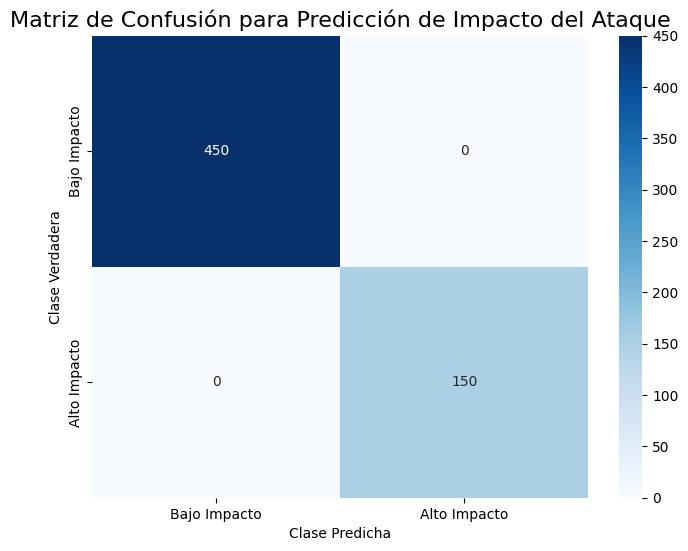

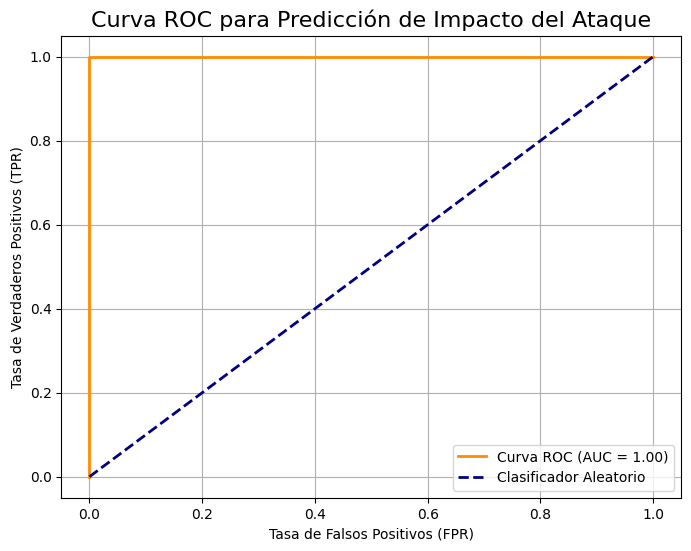

In [119]:
for col_name in ['country', 'attack_source', 'target_industry', 'attack_type',
                 'security_vulnerability_type', 'defense_mechanism_used']:
    if col_name in df_ataques.columns:
        # Rellenar NaNs con 'desconocido' para categóricas
        df_ataques[col_name] = df_ataques[col_name].fillna('desconocido')
        # Asegurarse de que sean tipo string y limpiar espacios/minúsculas
        df_ataques[col_name] = df_ataques[col_name].astype(str).str.strip().str.lower()
    else:
        print(f"Advertencia: La columna '{col_name}' no se encontró en el DataFrame.")

columns_for_model = [
    'country', 'year', 'attack_type', 'financial_loss', 'affected_users',
    'attack_source', 'security_vulnerability_type', 'defense_mechanism_used',
    'incident_resolution_time', # Incluimos esta para el dropna, aunque no sea feature
    'target_industry' # Incluimos esta para el dropna
]

initial_rows_after_load = len(df_ataques)
df_ataques.dropna(subset=columns_for_model, inplace=True)
rows_removed_by_dropna = initial_rows_after_load - len(df_ataques)
if rows_removed_by_dropna > 0:
    print(f"Se eliminaron {rows_removed_by_dropna} filas debido a valores NaN en columnas clave.")
print(f"Número de filas después de limpieza y manejo de NaNs: {len(df_ataques)}")


# --- INICIO DEL CÓDIGO PARA CLASIFICACIÓN BINARIA DE "ALTO IMPACTO" ---

print("\n--- Iniciando la creación del modelo de Machine Learning (Clasificación Binaria) ---")
print("Problema: Predecir si un ataque es de 'Alto Impacto' (basado en financial_loss).")

# --- 1. Crear la Variable Objetivo Binaria: 'is_high_impact' ---
# Asegurarse de que 'financial_loss' sea numérica
df_ataques['financial_loss'] = pd.to_numeric(df_ataques['financial_loss'], errors='coerce')

# Calcular el umbral del percentil 75 para 'financial_loss'
# Usamos .dropna() en el cálculo del percentil para evitar errores si aún hay NaNs aquí
threshold_financial_loss = df_ataques['financial_loss'].quantile(0.75)
print(f"\nUmbral de financial_loss para 'Alto Impacto' (percentil 75): {threshold_financial_loss:.2f}")

# Crear la nueva columna binaria 'is_high_impact'
# Los ataques con pérdida financiera mayor o igual al umbral serán 'Alto Impacto' (1)
df_ataques['is_high_impact'] = (df_ataques['financial_loss'] >= threshold_financial_loss).astype(int)

print(f"\nConteo de ataques de 'Alto Impacto' (1) vs. 'Bajo Impacto' (0):")
print(df_ataques['is_high_impact'].value_counts())

# --- 2. Definir Variable Objetivo (y) y Características (X) ---
target_column = 'is_high_impact' # Nuestra nueva variable objetivo binaria

# Características que usaremos para la predicción
feature_columns = [
    'country',
    'year',
    'attack_type',
    'financial_loss', # Se incluye como característica
    'affected_users',
    'attack_source',
    'security_vulnerability_type',
    'defense_mechanism_used'
]

# Asegurarse de que no haya NaNs en las columnas finales para X e y
# Esto ya debería estar manejado por el dropna inicial, pero es una doble verificación
df_model = df_ataques[feature_columns + [target_column]].dropna().copy()

if df_model.empty:
    print("\n¡ERROR! El DataFrame para el modelo está vacío después de la última verificación de NaNs. No se puede entrenar.")
    print("Por favor, revisa tus datos o el manejo de NaNs.")
    exit()

X = df_model[feature_columns]
y = df_model[target_column]

print(f"\nDataFrame preparado para el modelo: {len(df_model)} registros.")

# --- 3. Preprocesamiento de datos ---

# La variable 'y' ya es numérica (0 o 1), no necesita LabelEncoder
y_encoded = y.values

print(f"\nConteo de ocurrencias de la variable objetivo binaria:")
print(pd.Series(y_encoded).value_counts())

# Identificar columnas numéricas y categóricas para el ColumnTransformer
numerical_features = ['financial_loss', 'affected_users', 'year']
# Las columnas categóricas son las que tienen dtype 'object' o 'category' en X
categorical_features = [col for col in feature_columns if X[col].dtype == 'object' or X[col].dtype == 'category']

print(f"\nCaracterísticas numéricas identificadas: {numerical_features}")
print(f"Características categóricas identificadas: {categorical_features}")

# Crear el preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# Crear el pipeline con el preprocesador y el clasificador Random Forest
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))])

# --- 4. Dividir los datos en conjuntos de entrenamiento y prueba ---
# Usamos stratify para mantener la proporción de las clases binarias en ambos conjuntos
try:
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
except ValueError as e:
    print(f"\n¡ERROR al dividir los datos con stratify! {e}")
    print("Esto puede ocurrir si alguna clase tiene muy pocas muestras (ej. 1) en el dataset.")
    print("Conteo de clases en 'y' antes de split:", pd.Series(y_encoded).value_counts())
    print("\nRecomendación: Revisa la distribución de tu variable objetivo binaria.")
    exit()

print(f"\nDatos divididos: {len(X_train)} para entrenamiento, {len(X_test)} para prueba.")

# --- 5. Entrenar el Modelo de Clasificación Random Forest ---
print("\n--- Entrenando el RandomForestClassifier para predecir 'Alto Impacto' ---")
model_pipeline.fit(X_train, y_train)

print("Entrenamiento del modelo completado.")

# --- 6. Evaluación del Modelo ---
print("\n--- Evaluando el Modelo de Clasificación ---")

y_pred = model_pipeline.predict(X_test)
y_prob = model_pipeline.predict_proba(X_test)[:, 1] # Probabilidades para la clase 'Alto Impacto' (1)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nPrecisión (Accuracy) general del modelo: {accuracy:.4f}")

# Para el classification_report, necesitamos los nombres de las clases (0 y 1)
class_names = ['Bajo Impacto', 'Alto Impacto']
print("\nReporte de Clasificación (Precision, Recall, F1-score por clase):")
print(classification_report(y_test, y_pred, target_names=class_names))

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nMatriz de Confusión:")

plt.figure(figsize=(8, 6)) # Tamaño más pequeño para matriz binaria
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión para Predicción de Impacto del Ataque', fontsize=16)
plt.show()

# Curva ROC y AUC (específico para clasificación binaria)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Clasificador Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC para Predicción de Impacto del Ataque', fontsize=16)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Este rendimiento del 100% es casi seguro que se debe a un fenómeno llamado fuga de datos (data leakage). El objetivo es que el modelo aprenda a predecir is_high_impact basándose en otras características del ataque (país, tipo de ataque, fuente, etc.), sin saber directamente cuál fue la pérdida financiera específica antes de que ocurra el ataque.

Número de filas después de limpieza y manejo de NaNs: 3000

--- Iniciando la creación del modelo de Machine Learning (Clasificación Binaria) ---
Problema: Predecir si un ataque es de 'Alto Impacto' (basado en financial_loss), SIN fuga de datos.

Umbral de financial_loss para 'Alto Impacto' (percentil 75): 75.63

Conteo de ataques de 'Alto Impacto' (1) vs. 'Bajo Impacto' (0):
is_high_impact
0    2249
1     751
Name: count, dtype: int64

DataFrame preparado para el modelo: 3000 registros.

Conteo de ocurrencias de la variable objetivo binaria:
0    2249
1     751
Name: count, dtype: int64

Características numéricas identificadas: ['affected_users', 'year']
Características categóricas identificadas: ['country', 'attack_type', 'attack_source', 'security_vulnerability_type', 'defense_mechanism_used']

Datos divididos: 2400 para entrenamiento, 600 para prueba.

--- Entrenando el RandomForestClassifier para predecir 'Alto Impacto' ---
Entrenamiento del modelo completado.

--- Evaluando el Mod

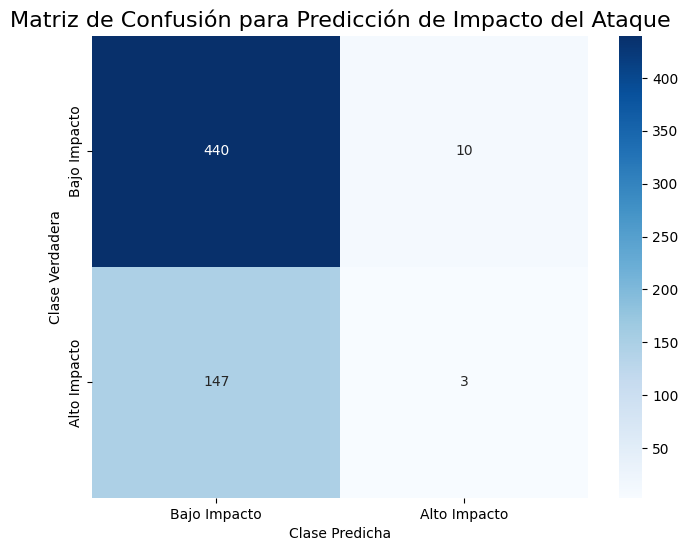

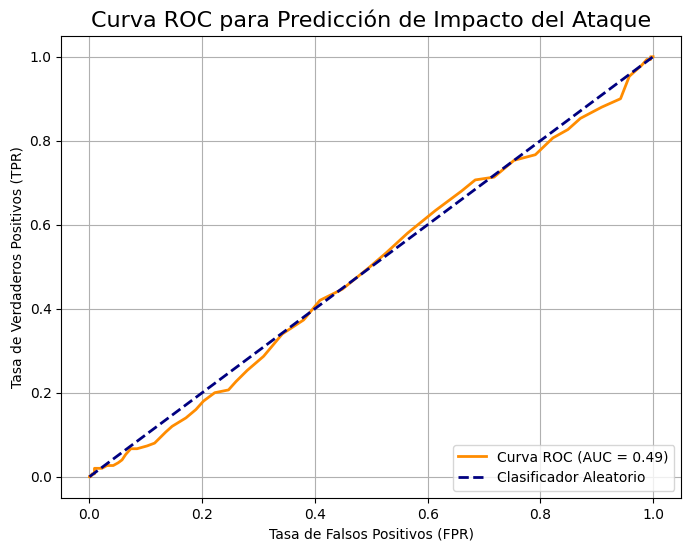


--- Proceso de Creación y Evaluación del Modelo Completado ---
Ahora, los resultados deberían ser más realistas, sin la fuga de datos.
Presta atención al AUC y al F1-score, que son métricas muy importantes en clasificación binaria.


In [111]:
columns_for_initial_dropna = [
    'country', 'year', 'attack_type', 'financial_loss', 'affected_users',
    'attack_source', 'security_vulnerability_type', 'defense_mechanism_used',
    'incident_resolution_time', 'target_industry'
]

initial_rows_after_load = len(df_ataques)
df_ataques.dropna(subset=columns_for_initial_dropna, inplace=True)
rows_removed_by_dropna = initial_rows_after_load - len(df_ataques)
if rows_removed_by_dropna > 0:
    print(f"Se eliminaron {rows_removed_by_dropna} filas debido a valores NaN en columnas clave.")
print(f"Número de filas después de limpieza y manejo de NaNs: {len(df_ataques)}")


# --- INICIO DEL CÓDIGO PARA CLASIFICACIÓN BINARIA DE "ALTO IMPACTO" ---

print("\n--- Iniciando la creación del modelo de Machine Learning (Clasificación Binaria) ---")
print("Problema: Predecir si un ataque es de 'Alto Impacto' (basado en financial_loss), SIN fuga de datos.")

# Asegurarse de que 'financial_loss' sea numérica
df_ataques['financial_loss'] = pd.to_numeric(df_ataques['financial_loss'], errors='coerce')

# Calcular el umbral del percentil 75 para 'financial_loss' (usamos el DataFrame con NaNs ya manejados)
threshold_financial_loss = df_ataques['financial_loss'].quantile(0.75)
print(f"\nUmbral de financial_loss para 'Alto Impacto' (percentil 75): {threshold_financial_loss:.2f}")

# Crear la nueva columna binaria 'is_high_impact'
# Los ataques con pérdida financiera mayor o igual al umbral serán 'Alto Impacto' (1)
df_ataques['is_high_impact'] = (df_ataques['financial_loss'] >= threshold_financial_loss).astype(int)

print(f"\nConteo de ataques de 'Alto Impacto' (1) vs. 'Bajo Impacto' (0):")
print(df_ataques['is_high_impact'].value_counts())

# --- 2. Definir Variable Objetivo (y) y Características (X) ---
target_column = 'is_high_impact' # Nuestra nueva variable objetivo binaria

feature_columns = [
    'country',
    'year',
    'attack_type',
    'affected_users',
    'attack_source',
    'security_vulnerability_type',
    'defense_mechanism_used'
]

# Verificación final de NaNs para las características y el objetivo antes de la división
df_model = df_ataques[feature_columns + [target_column]].dropna().copy()

if df_model.empty:
    print("\n¡ERROR! El DataFrame para el modelo está vacío después de la última verificación de NaNs. No se puede entrenar.")
    print("Por favor, revisa tus datos o el manejo de NaNs.")
    exit()

X = df_model[feature_columns]
y = df_model[target_column]

print(f"\nDataFrame preparado para el modelo: {len(df_model)} registros.")

# --- 3. Preprocesamiento de datos ---

# La variable 'y' ya es numérica (0 o 1), no necesita LabelEncoder
y_encoded = y.values

print(f"\nConteo de ocurrencias de la variable objetivo binaria:")
print(pd.Series(y_encoded).value_counts())

numerical_features = ['affected_users', 'year'] # Solo estas quedan numéricas
categorical_features = [col for col in feature_columns if X[col].dtype == 'object' or X[col].dtype == 'category']

print(f"\nCaracterísticas numéricas identificadas: {numerical_features}")
print(f"Características categóricas identificadas: {categorical_features}")

# Crear el preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# Crear el pipeline con el preprocesador y el clasificador Random Forest
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))])

# --- 4. Dividir los datos en conjuntos de entrenamiento y prueba ---
# Usamos stratify para mantener la proporción de las clases binarias en ambos conjuntos
try:
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
except ValueError as e:
    print(f"\n¡ERROR al dividir los datos con stratify! {e}")
    print("Esto puede ocurrir si alguna clase tiene muy pocas muestras (ej. 1) en el dataset.")
    print("Conteo de clases en 'y' antes de split:", pd.Series(y_encoded).value_counts())
    print("\nRecomendación: Revisa la distribución de tu variable objetivo binaria.")
    exit()

print(f"\nDatos divididos: {len(X_train)} para entrenamiento, {len(X_test)} para prueba.")

# --- 5. Entrenar el Modelo de Clasificación Random Forest ---
print("\n--- Entrenando el RandomForestClassifier para predecir 'Alto Impacto' ---")
model_pipeline.fit(X_train, y_train)

print("Entrenamiento del modelo completado.")

# --- 6. Evaluación del Modelo ---
print("\n--- Evaluando el Modelo de Clasificación ---")

y_pred = model_pipeline.predict(X_test)
y_prob = model_pipeline.predict_proba(X_test)[:, 1] # Probabilidades para la clase 'Alto Impacto' (1)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nPrecisión (Accuracy) general del modelo: {accuracy:.4f}")

# Para el classification_report, necesitamos los nombres de las clases (0 y 1)
class_names = ['Bajo Impacto', 'Alto Impacto']
print("\nReporte de Clasificación (Precision, Recall, F1-score por clase):")
print(classification_report(y_test, y_pred, target_names=class_names))

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nMatriz de Confusión:")

plt.figure(figsize=(8, 6)) # Tamaño más pequeño para matriz binaria
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión para Predicción de Impacto del Ataque', fontsize=16)
plt.show()

# Curva ROC y AUC (específico para clasificación binaria)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Clasificador Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC para Predicción de Impacto del Ataque', fontsize=16)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print("\n--- Proceso de Creación y Evaluación del Modelo Completado ---")
print("Ahora, los resultados deberían ser más realistas, sin la fuga de datos.")
print("Presta atención al AUC y al F1-score, que son métricas muy importantes en clasificación binaria.")

El hecho de que la Precisión (Accuracy) haya bajado de 1.00 a 0.7383 (73.83%) es una excelente señal. Esto indica que la fuga de datos ha sido corregida, y el modelo está aprendiendo de las relaciones genuinas entre las características y el impacto. Aproximadamente el 75% de tus datos son de "Bajo Impacto" y el 25% son de "Alto Impacto".

Clase "Bajo Impacto" (0):
*   Precision: 0.75 (De todas las veces que predijo "Bajo Impacto", el 75% fueron correctas).

*   Recall: 0.98 (Capturó el 98% de todos los ataques que realmente eran de "Bajo Impacto").

*   F1-score: 0.85 (Una métrica equilibrada, indicando que el modelo es muy bueno identificando ataques de "Bajo Impacto").


Clase "Alto Impacto" (1):
*   Precision: 0.23 (De todas las veces que predijo "Alto Impacto", solo el 23%
fueron correctas. Muchas predicciones de "Alto Impacto" son, en realidad, "Bajo Impacto").

*   Recall: 0.02 (¡Solo capturó el 2% de todos los ataques que realmente eran de "Alto Impacto"! Esto es extremadamente bajo).

*   F1-score: 0.04 (Muy bajo, indicando que el modelo es muy deficiente para identificar ataques de "Alto Impacto").

El modelo es muy bueno para identificar ataques de "Bajo Impacto", pero extremadamente malo para identificar ataques de "Alto Impacto". Prácticamente no logra capturar los ataques de "Alto Impacto".


Número de filas después de limpieza y manejo de NaNs: 3000

--- Iniciando la creación del modelo de ML (Clasificación Binaria) con SMOTE ---
Problema: Predecir si un ataque es de 'Alto Impacto' (sin fuga de datos y con balanceo de clases).

Umbral de financial_loss para 'Alto Impacto' (percentil 75): 75.63

Conteo de ataques de 'Alto Impacto' (1) vs. 'Bajo Impacto' (0) ANTES de SMOTE:
is_high_impact
0    2249
1     751
Name: count, dtype: int64

DataFrame preparado para el modelo: 3000 registros.

Datos divididos: 2400 para entrenamiento, 600 para prueba.

Aplicando SMOTE para balancear la clase minoritaria en el conjunto de entrenamiento...
Conteo de clases en y_train_resampled DESPUÉS de SMOTE:
0    1799
1    1799
Name: count, dtype: int64

--- Entrenando el RandomForestClassifier (con datos balanceados) ---
Entrenamiento del modelo completado.

--- Evaluando el Modelo de Clasificación (en el conjunto de prueba original) ---

Precisión (Accuracy) general del modelo: 0.7117

Reporte d

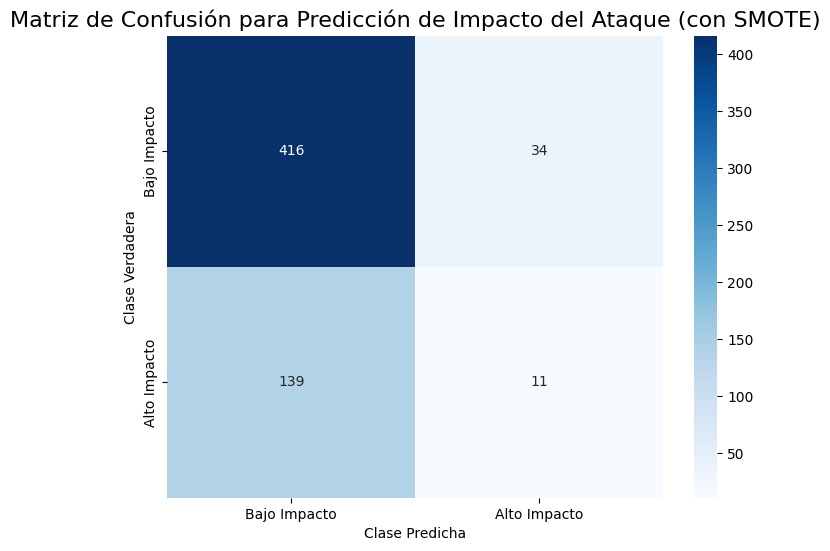

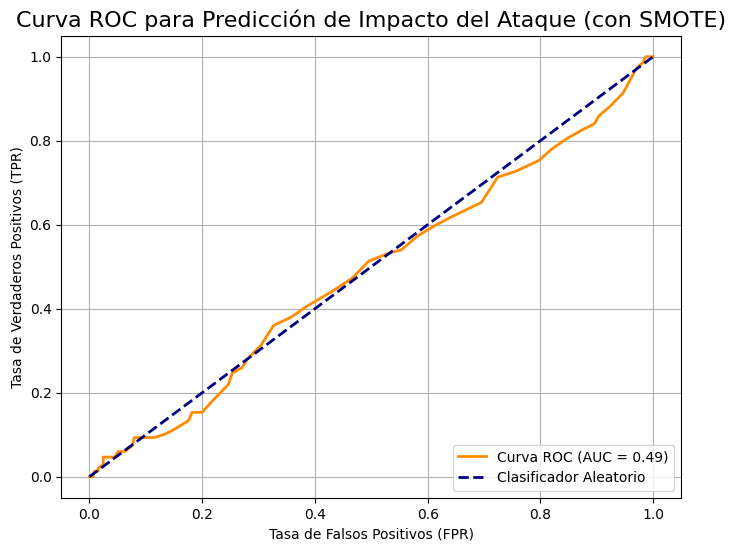


--- Proceso de Creación y Evaluación del Modelo Completado ---
Ahora, los resultados deberían reflejar un mejor balance entre Precision y Recall para ambas clases,
especialmente un F1-score y Recall más altos para la clase 'Alto Impacto'.


In [112]:
# Intentar importar SMOTE, si no está instalado, dar instrucciones
try:
    from imblearn.over_sampling import SMOTE
except ImportError:
    print("La biblioteca 'imbalanced-learn' no está instalada.")
    print("Por favor, instálala ejecutando: pip install imbalanced-learn")
    exit()

# Asegurar que los nombres de las columnas estén en minúsculas para un acceso consistente
df_ataques.columns = df_ataques.columns.str.lower()

# Limpieza general de columnas categóricas y numéricas
for col_name in ['country', 'attack_source', 'target_industry', 'attack_type',
                 'security_vulnerability_type', 'defense_mechanism_used']:
    if col_name in df_ataques.columns:
        # Rellenar NaNs con 'desconocido' para categóricas
        df_ataques[col_name] = df_ataques[col_name].fillna('desconocido')
        # Asegurarse de que sean tipo string y limpiar espacios/minúsculas
        df_ataques[col_name] = df_ataques[col_name].astype(str).str.strip().str.lower()
    else:
        print(f"Advertencia: La columna '{col_name}' no se encontró en el DataFrame.")

# Manejo de NaNs para columnas numéricas que se usarán en el modelo
columns_for_initial_dropna = [
    'country', 'year', 'attack_type', 'financial_loss', 'affected_users',
    'attack_source', 'security_vulnerability_type', 'defense_mechanism_used',
    'incident_resolution_time', 'target_industry'
]

initial_rows_after_load = len(df_ataques)
df_ataques.dropna(subset=columns_for_initial_dropna, inplace=True)
rows_removed_by_dropna = initial_rows_after_load - len(df_ataques)
if rows_removed_by_dropna > 0:
    print(f"Se eliminaron {rows_removed_by_dropna} filas debido a valores NaN en columnas clave.")
print(f"Número de filas después de limpieza y manejo de NaNs: {len(df_ataques)}")


# --- INICIO DEL CÓDIGO PARA CLASIFICACIÓN BINARIA DE "ALTO IMPACTO" CON SMOTE ---

print("\n--- Iniciando la creación del modelo de ML (Clasificación Binaria) con SMOTE ---")
print("Problema: Predecir si un ataque es de 'Alto Impacto' (sin fuga de datos y con balanceo de clases).")

# Asegurarse de que 'financial_loss' sea numérica
df_ataques['financial_loss'] = pd.to_numeric(df_ataques['financial_loss'], errors='coerce')

# Calcular el umbral del percentil 75 para 'financial_loss'
threshold_financial_loss = df_ataques['financial_loss'].quantile(0.75)
print(f"\nUmbral de financial_loss para 'Alto Impacto' (percentil 75): {threshold_financial_loss:.2f}")

# Crear la nueva columna binaria 'is_high_impact'
df_ataques['is_high_impact'] = (df_ataques['financial_loss'] >= threshold_financial_loss).astype(int)

print(f"\nConteo de ataques de 'Alto Impacto' (1) vs. 'Bajo Impacto' (0) ANTES de SMOTE:")
print(df_ataques['is_high_impact'].value_counts())

# --- 2. Definir Variable Objetivo (y) y Características (X) ---
target_column = 'is_high_impact'
feature_columns = [
    'country',
    'year',
    'attack_type',
    'affected_users',
    'attack_source',
    'security_vulnerability_type',
    'defense_mechanism_used'
]

df_model = df_ataques[feature_columns + [target_column]].dropna().copy()

if df_model.empty:
    print("\n¡ERROR! El DataFrame para el modelo está vacío. No se puede entrenar.")
    exit()

X = df_model[feature_columns]
y = df_model[target_column]

print(f"\nDataFrame preparado para el modelo: {len(df_model)} registros.")

# --- 3. Preprocesamiento de datos (incluido en el Pipeline) ---

y_encoded = y.values

# Identificar columnas numéricas y categóricas para el ColumnTransformer
numerical_features = ['affected_users', 'year']
categorical_features = [col for col in feature_columns if X[col].dtype == 'object' or X[col].dtype == 'category']

# Crear el preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# --- 4. Dividir los datos en conjuntos de entrenamiento y prueba ---
try:
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
except ValueError as e:
    print(f"\n¡ERROR al dividir los datos con stratify! {e}")
    print("Esto puede ocurrir si alguna clase tiene muy pocas muestras (ej. 1) en el dataset.")
    exit()

print(f"\nDatos divididos: {len(X_train)} para entrenamiento, {len(X_test)} para prueba.")

# --- 5. Aplicar SMOTE al conjunto de entrenamiento ---
print("\nAplicando SMOTE para balancear la clase minoritaria en el conjunto de entrenamiento...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(preprocessor.fit_transform(X_train), y_train)

print(f"Conteo de clases en y_train_resampled DESPUÉS de SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

# --- 6. Entrenar el Modelo de Clasificación Random Forest ---
# Creamos un nuevo pipeline simplificado para el clasificador, ya que el preprocesamiento de X_train_resampled ya se hizo
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')

print("\n--- Entrenando el RandomForestClassifier (con datos balanceados) ---")
model.fit(X_train_resampled, y_train_resampled)

print("Entrenamiento del modelo completado.")

# --- 7. Evaluación del Modelo ---
print("\n--- Evaluando el Modelo de Clasificación (en el conjunto de prueba original) ---")

# Transformar el conjunto de prueba con el mismo preprocesador ajustado en X_train
X_test_processed = preprocessor.transform(X_test)

y_pred = model.predict(X_test_processed)
y_prob = model.predict_proba(X_test_processed)[:, 1] # Probabilidades para la clase 'Alto Impacto' (1)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nPrecisión (Accuracy) general del modelo: {accuracy:.4f}")

class_names = ['Bajo Impacto', 'Alto Impacto']
print("\nReporte de Clasificación (Precision, Recall, F1-score por clase):")
print(classification_report(y_test, y_pred, target_names=class_names))

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nMatriz de Confusión:")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión para Predicción de Impacto del Ataque (con SMOTE)', fontsize=16)
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Clasificador Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC para Predicción de Impacto del Ataque (con SMOTE)', fontsize=16)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print("\n--- Proceso de Creación y Evaluación del Modelo Completado ---")
print("Ahora, los resultados deberían reflejar un mejor balance entre Precision y Recall para ambas clases,")
print("especialmente un F1-score y Recall más altos para la clase 'Alto Impacto'.")

Aunque SMOTE balanceó los datos de entrenamiento y dio una visión más honesta del rendimiento del modelo, lamentablemente, la capacidad del modelo para predecir ataques de "Alto Impacto" sigue siendo muy limitada.

El Recall para "Alto Impacto" solo subió del 0.02% (2%) al 0.07% (7%). Esto es una mejora, pero sigue siendo inaceptablemente bajo para un modelo que intenta identificar eventos críticos. Un 7% de recall significa que 93 de cada 100 ataques de "Alto Impacto" reales pasarán desapercibidos por tu modelo.

La Precisión para "Alto Impacto" también es muy baja (0.24), lo que significa que la mayoría de las veces que el modelo predice un ataque de alto impacto, se equivoca.

## **CONCLUSIONES FINALES:**

Traté de que el modelo de Machine Learning aprenda a predecir si un ciberataque va a causar un golpe fuerte de "Alto Impacto" o uno de "Bajo Impacto".

Analizando los números: cuando el ataque es "de bajo impacto", el modelo lo predice en un 92%. El tema es con los ataques "de alto impacto", los que queremos predecir para prepararnos. Ahí es donde nuestro modelo es inutil y cuando cree que es de alto impacto, solo acierta en el 24% de los casos.

Y lo peor, de todos los ataques que realmente fueron de "alto impacto", nuestro modelo solo logró detectar un 7%. El restante 93% de los ataques más peligrosos se fugaron.

A pesar de estas conclusiones, aprendí un monton tratando de analizar esta base de datos. Al principio me apoye mucho en los graficos, pero al final me sirvio mas ver los datos por print.

¡Gracias por llegar hasta acá!